# 1. Data Loading

### 1.1 Create PyTorch Datasets and DataLoaders

In [1]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 1
%autoreload 2

# Import required libraries
import os
import numpy as np

import torch
from torch.utils.data import DataLoader
import wandb
from datetime import datetime # Import datetime for timestamp

# Local modules
from utils.data_persistence import load_scalers
from utils.plot_utils import plot_training_history, plot_evaluation_metrics
from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info, save_model, load_model

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# ========== Model training hyperparameters =========
PATIENCE = 10
LR = 0.0001
# Debug mode to test code. Set to False for actual training
DEBUG_MODE = False

if DEBUG_MODE:
    # Local debug settings (to check if the code is working)
    # Will only run 10 batches/epoch for 10 epochs
    N_EPOCHS = 10
    BATCH_SIZE = 64
    NUM_WORKERS = 4
else:
    # Remote server settings (to train the model, recommend using Otter lab machine)
    N_EPOCHS = 30
    BATCH_SIZE = 2 ** 13   # = 8192 samples
    NUM_WORKERS = 16

# ================= Wandb settings =============
USE_WANDB = True
WANDB_USERNAME = "tin-hoang"
WANDB_PROJECT = "EEEM073-Solar-Radiation"

# =========== Time series hyperparameters ===========
# Number of timesteps to look back when creating sequences
LOOKBACK = 24

# Choose features to use in modeling
TIME_FEATURES = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',      # Categorical feature
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo',
    'nighttime_mask',  # New field from preprocess_data
    'cld_opd_dcomp',
    'aod'
]
STATIC_FEATURES = ['latitude', 'longitude', 'elevation']
# Target variable
TARGET_VARIABLE = 'ghi'

pvlib not available, using default solar position calculation
Using cuda device


In [2]:
from utils.data_persistence import load_normalized_data

TRAIN_PREPROCESSED_DATA_PATH = "data/processed/train_normalized_20250430_145157.h5"
VAL_PREPROCESSED_DATA_PATH = "data/processed/val_normalized_20250430_145205.h5"
TEST_PREPROCESSED_DATA_PATH = "data/processed/test_normalized_20250430_145205.h5"

# Load sequences
train_data, metadata = load_normalized_data(TRAIN_PREPROCESSED_DATA_PATH)

SCALER_PATH = "data/processed/scalers_20250430_145206.pkl"
scalers = load_scalers(SCALER_PATH)

# Print metadata
print(f"Train set | Metadata: {metadata}")
# Print created time
print(f"Train set | Created time: {metadata['created_time'] if 'created_time' in metadata else 'No created time'}")
# Print raw files
print(f"Train set | Raw files: {metadata['raw_files'] if 'raw_files' in metadata else 'No raw files'}")

# Print data structure and shape
print(f"Train set | Data structure:")
for key, value in train_data.items():
    print(f"  {key} shape: {value.shape}")

Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded 16 scalers from data/processed/scalers_20250430_145206.pkl
Train set | Metadata: {'created_time': '2025-04-30 14:51:57'}
Train set | Created time: 2025-04-30 14:51:57
Train set | Raw files: No raw files
Train set | Data structure:
  air_temperature shape: (70128, 105)
  aod shape: (70128, 105)
  cld_opd_dcomp shape: (70128, 105)
  cld_press_acha shape: (70128, 105)
  cld_reff_dcomp shape: (70128, 105)
  clearsky_ghi shape: (70128, 105)
  cloud_type shape: (70128, 105)
  day_cos shape: (70128,)
  day_sin shape: (70128,)
  dow_cos shape: (70128,)
  dow_sin shape: (70128,)
  elevation shape: (105,)
  ghi shape: (70128, 105)
  hour_cos shape: (70128,)
  hour_sin shape: (70128,)
  latitude shape: (105,)
  longitude shape: (105,)
  month_cos shape: (70128,)
  month_sin shape: (70128,)
  nighttime_mask shape: (70128, 105)
  relative_humidity shape: (70128, 105)
  solar_zenith_angle shape: (70128, 105)
  surf

In [3]:
from utils.timeseriesdataset import TimeSeriesDataset

# Create datasets
train_dataset = TimeSeriesDataset(TRAIN_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                 selected_features=SELECTED_FEATURES, include_target_history=False,
                                 static_features=STATIC_FEATURES)
val_dataset = TimeSeriesDataset(VAL_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                               selected_features=SELECTED_FEATURES, include_target_history=False,
                               static_features=STATIC_FEATURES)
test_dataset = TimeSeriesDataset(TEST_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                selected_features=SELECTED_FEATURES, include_target_history=False,
                                static_features=STATIC_FEATURES)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Using time feature keys: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Using static features: ['latitude', 'longitude', 'elevation']
Not using target field history for autoregression
Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded normalized data file (1/1): data/processed/train_normalized_20250430_145157.h5
Loaded data with 27 features
Using 11 selected features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Temporal features: ['day_cos', 'day_sin', 'dow_cos', 'dow_sin', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin']
Static features: ['latitude', 'longitude', 'elevation']
Time series features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total

In [4]:
# Get a batch to determine input dimensions
batch = next(iter(train_loader))

# Check sample batch
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
    elif isinstance(value, list):
        print(f"{key} length: {len(value)}")

# Extract dimensions from a batch (more reliable)
temporal_features = batch['temporal_features']
static_features = batch['static_features']
TEMPORAL_FEATURES_SHAPE = list(temporal_features.shape)
STATIC_FEATURES_SHAPE = list(static_features.shape)

# Check if we have 3D temporal features (batch, seq_len, features)
if len(temporal_features.shape) == 3:
    temporal_dim = temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = temporal_features.shape[1]

static_dim = static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Batch temporal_features shape: {TEMPORAL_FEATURES_SHAPE}")
print(f"  - Batch static_features shape: {STATIC_FEATURES_SHAPE}")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")

static_features shape: torch.Size([8192, 3])
target shape: torch.Size([8192])
temporal_features shape: torch.Size([8192, 24, 19])
air_temperature shape: torch.Size([8192, 24])
aod shape: torch.Size([8192, 24])
cld_opd_dcomp shape: torch.Size([8192, 24])
clearsky_ghi shape: torch.Size([8192, 24])
cloud_type shape: torch.Size([8192, 24])
nighttime_mask shape: torch.Size([8192, 24])
relative_humidity shape: torch.Size([8192, 24])
solar_zenith_angle shape: torch.Size([8192, 24])
surface_albedo shape: torch.Size([8192, 24])
total_precipitable_water shape: torch.Size([8192, 24])
wind_speed shape: torch.Size([8192, 24])
time_index_local length: 8192
current_hour_sin shape: torch.Size([8192])
current_hour_cos shape: torch.Size([8192])
current_day_sin shape: torch.Size([8192])
current_day_cos shape: torch.Size([8192])
current_month_sin shape: torch.Size([8192])
current_month_cos shape: torch.Size([8192])
current_dow_sin shape: torch.Size([8192])
current_dow_cos shape: torch.Size([8192])
  Input

## 2. Model Training Setup

## 2.1 Setting parameters

In [5]:
from torchinfo import summary

from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info

# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)

True

## 2.2 Setup Experiment Pipeline

In [6]:
def run_experiment_pipeline(model, train_loader, val_loader, test_loader, model_name, epochs=30, patience=5, lr=0.001):
    """
    Run the experiment pipeline for a given model.

    Args:
        model: The model to train.
        train_loader: The training data loader.
        val_loader: The validation data loader.
        test_loader: The test data loader.
        model_name: The name of the model.
        epochs: The number of epochs to train the model.
        patience: The number of epochs to wait before early stopping.
        lr: The learning rate for the model.
    """
    history, val_metrics, test_metrics = None, None, None

    # Get the current config
    CONFIG = {}
    cur_globals = globals().copy()
    for x in cur_globals:
        # Only get the variables that are uppercase and not digits
        if x.upper() == x and not x.startswith('_') and not x == "CONFIG":
            CONFIG[x] = cur_globals[x]

    try:
        print(f"Training {model_name} model...")
        history = train_model(
            model,
            train_loader,
            val_loader,
            model_name=model_name,
            epochs=epochs,
            patience=patience,
            lr=lr,
            target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
            config=CONFIG,
            debug_mode=DEBUG_MODE,
        )
        training_plot = plot_training_history(history, model_name=model_name)

        print(f"\nEvaluating {model_name} model on test set...")
        test_metrics = evaluate_model(
            model,
            test_loader,
            scalers[f'{TARGET_VARIABLE}_scaler'],
            model_name=f"{model_name} - Test"
        )
        test_plot = plot_evaluation_metrics(test_metrics, model_name=f"{model_name} - Test")

        # ========== Save Best Model Checkpoint ===========
        checkpoint_dir = "checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Generate timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Construct filename with timestamp and directory
        model_filename = f"{model_name}_best_{timestamp}.pt"
        model_path = os.path.join(checkpoint_dir, model_filename)

        # Combine time keys and selected features for the complete temporal feature set
        all_temporal_features = TIME_FEATURES + SELECTED_FEATURES

        # Save the model with metadata using the new save_model function
        save_model(
            model=model,
            filepath=model_path,
            metadata={
                "model_name": model_name,
                "timestamp": timestamp,
                "train_metrics": {
                    "final_train_loss": history["train_loss"][-1] if history and "train_loss" in history else None,
                    "final_train_mae": history["train_mae"][-1] if history and "train_mae" in history else None,
                    "final_val_loss": history["val_loss"][-1] if history and "val_loss" in history else None,
                    "final_val_mae": history["val_mae"][-1] if history and "val_mae" in history else None,
                },
                "test_metrics": {
                    "mse": test_metrics["mse"] if test_metrics else None,
                    "rmse": test_metrics["rmse"] if test_metrics else None,
                    "mae": test_metrics["mae"] if test_metrics else None,
                    "r2": test_metrics["r2"] if test_metrics else None,
                }
            },
            temporal_features=all_temporal_features,
            static_features=STATIC_FEATURES,
            time_feature_keys=TIME_FEATURES,
            config=CONFIG
        )

        print(f"Best model saved to {model_path}")

        # Log saved model path to wandb if enabled
        if is_wandb_enabled():
            wandb.save(model_path)
            print(f"Saved model checkpoint logged to wandb: {model_path}")
            wandb.log({"plots/history_plot": wandb.Image(training_plot)})
            wandb.log({"plots/predictions_plot": wandb.Image(test_plot)})

    finally:
        # Finish wandb run if it's still open
        if is_wandb_enabled():
            wandb.finish()

        # Clear GPU memory
        torch.cuda.empty_cache()

    return history, val_metrics, test_metrics

# 3. Model Experiments

### 3.1 LSTM Model

In [7]:
from models.lstm import LSTMModel

# Create LSTM model
lstm_model = LSTMModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dim=128,
    num_layers=2,
    dropout=0.3
).to(device)

# Print the model
print_model_info(lstm_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: LSTMModel
Total parameters: 221,441
Trainable parameters: 221,441
Non-trainable parameters: 0

Model structure:
LSTMModel(
  (lstm): LSTM(19, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (static_proj): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True,

Training LSTM model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for LSTM


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training config: {'PATIENCE': 10, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 


Validation LSTM (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 5727.63, RMSE: 75.68, MAE: 42.94, R²: 0.9407, WAPE: 18.39%
  Daytime:  MSE: 11408.91, RMSE: 106.81, MAE: 79.35, R²: 0.8642, WAPE: 16.95%
  Nighttime: MSE: 79.79, RMSE: 8.93, MAE: 6.74, R²: -29.9189, WAPE: 2131.90%
  Inference Speed: 8130383.16 samples/sec, 0.0001 ms/sample
  Total time: 0.0111 sec for 90112 samples
Epoch 1/30 | Train Loss: 43230.8203, Train MAE: 144.5161 | Val Loss: 5727.6270, Val MAE: 42.9378 | LR: 0.000100



Validation LSTM (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 4852.56, RMSE: 69.66, MAE: 39.51, R²: 0.9498, WAPE: 16.92%
  Daytime:  MSE: 9699.74, RMSE: 98.49, MAE: 74.57, R²: 0.8846, WAPE: 15.93%
  Nighttime: MSE: 33.91, RMSE: 5.82, MAE: 4.65, R²: -12.1391, WAPE: 1472.79%
  Inference Speed: 8455227.45 samples/sec, 0.0001 ms/sample
  Total time: 0.0107 sec for 90112 samples
Epoch 2/30 | Train Loss: 10126.0977, Train MAE: 66.1333 | Val Loss: 4852.5552, Val MAE: 39.5067 | LR: 0.000100



Validation LSTM (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 4546.14, RMSE: 67.43, MAE: 37.81, R²: 0.9529, WAPE: 16.19%
  Daytime:  MSE: 9098.68, RMSE: 95.39, MAE: 72.93, R²: 0.8917, WAPE: 15.58%
  Nighttime: MSE: 20.40, RMSE: 4.52, MAE: 2.90, R²: -6.9071, WAPE: 919.03%
  Inference Speed: 7444937.11 samples/sec, 0.0001 ms/sample
  Total time: 0.0121 sec for 90112 samples
Epoch 3/30 | Train Loss: 8308.2549, Train MAE: 60.0951 | Val Loss: 4546.1421, Val MAE: 37.8112 | LR: 0.000100



Validation LSTM (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3533.44, RMSE: 59.44, MAE: 32.31, R²: 0.9634, WAPE: 13.84%
  Daytime:  MSE: 7067.44, RMSE: 84.07, MAE: 61.58, R²: 0.9159, WAPE: 13.16%
  Nighttime: MSE: 20.25, RMSE: 4.50, MAE: 3.21, R²: -6.8473, WAPE: 1016.69%
  Inference Speed: 6253116.52 samples/sec, 0.0002 ms/sample
  Total time: 0.0144 sec for 90112 samples
Epoch 4/30 | Train Loss: 7416.2334, Train MAE: 57.0779 | Val Loss: 3533.4417, Val MAE: 32.3109 | LR: 0.000100



Validation LSTM (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3351.40, RMSE: 57.89, MAE: 31.17, R²: 0.9653, WAPE: 13.35%
  Daytime:  MSE: 6695.71, RMSE: 81.83, MAE: 58.48, R²: 0.9203, WAPE: 12.50%
  Nighttime: MSE: 26.78, RMSE: 5.17, MAE: 4.02, R²: -9.3772, WAPE: 1273.25%
  Inference Speed: 6723181.99 samples/sec, 0.0001 ms/sample
  Total time: 0.0134 sec for 90112 samples
Epoch 5/30 | Train Loss: 7133.8232, Train MAE: 56.2263 | Val Loss: 3351.3994, Val MAE: 31.1734 | LR: 0.000100



Validation LSTM (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3128.05, RMSE: 55.93, MAE: 28.50, R²: 0.9676, WAPE: 12.21%
  Daytime:  MSE: 6257.22, RMSE: 79.10, MAE: 54.41, R²: 0.9255, WAPE: 11.62%
  Nighttime: MSE: 17.29, RMSE: 4.16, MAE: 2.74, R²: -5.7009, WAPE: 868.27%
  Inference Speed: 6809056.75 samples/sec, 0.0001 ms/sample
  Total time: 0.0132 sec for 90112 samples
Epoch 6/30 | Train Loss: 6635.7466, Train MAE: 53.9343 | Val Loss: 3128.0466, Val MAE: 28.4992 | LR: 0.000100



Validation LSTM (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3338.88, RMSE: 57.78, MAE: 32.01, R²: 0.9654, WAPE: 13.71%
  Daytime:  MSE: 6661.83, RMSE: 81.62, MAE: 58.99, R²: 0.9207, WAPE: 12.60%
  Nighttime: MSE: 35.48, RMSE: 5.96, MAE: 5.18, R²: -12.7495, WAPE: 1640.61%
  Inference Speed: 7468032.45 samples/sec, 0.0001 ms/sample
  Total time: 0.0121 sec for 90112 samples
Epoch 7/30 | Train Loss: 6482.9302, Train MAE: 53.1463 | Val Loss: 3338.8765, Val MAE: 32.0077 | LR: 0.000100



Validation LSTM (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3289.80, RMSE: 57.36, MAE: 31.33, R²: 0.9659, WAPE: 13.42%
  Daytime:  MSE: 6574.71, RMSE: 81.08, MAE: 58.42, R²: 0.9218, WAPE: 12.48%
  Nighttime: MSE: 24.23, RMSE: 4.92, MAE: 4.40, R²: -8.3907, WAPE: 1393.69%
  Inference Speed: 7828278.66 samples/sec, 0.0001 ms/sample
  Total time: 0.0115 sec for 90112 samples
Epoch 8/30 | Train Loss: 6242.0742, Train MAE: 51.7909 | Val Loss: 3289.8044, Val MAE: 31.3345 | LR: 0.000100



Validation LSTM (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3012.79, RMSE: 54.89, MAE: 28.47, R²: 0.9688, WAPE: 12.19%
  Daytime:  MSE: 6013.08, RMSE: 77.54, MAE: 52.34, R²: 0.9284, WAPE: 11.18%
  Nighttime: MSE: 30.16, RMSE: 5.49, MAE: 4.73, R²: -10.6876, WAPE: 1495.99%
  Inference Speed: 9145746.55 samples/sec, 0.0001 ms/sample
  Total time: 0.0099 sec for 90112 samples
Epoch 9/30 | Train Loss: 6633.9551, Train MAE: 53.4796 | Val Loss: 3012.7876, Val MAE: 28.4651 | LR: 0.000100



Validation LSTM (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3081.68, RMSE: 55.51, MAE: 29.59, R²: 0.9681, WAPE: 12.67%
  Daytime:  MSE: 6144.49, RMSE: 78.39, MAE: 53.61, R²: 0.9269, WAPE: 11.45%
  Nighttime: MSE: 36.90, RMSE: 6.07, MAE: 5.72, R²: -13.2996, WAPE: 1810.16%
  Inference Speed: 9059809.24 samples/sec, 0.0001 ms/sample
  Total time: 0.0099 sec for 90112 samples
Epoch 10/30 | Train Loss: 6011.1587, Train MAE: 50.2818 | Val Loss: 3081.6780, Val MAE: 29.5931 | LR: 0.000100



Validation LSTM (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2947.74, RMSE: 54.29, MAE: 27.27, R²: 0.9695, WAPE: 11.68%
  Daytime:  MSE: 5898.41, RMSE: 76.80, MAE: 51.21, R²: 0.9298, WAPE: 10.94%
  Nighttime: MSE: 14.44, RMSE: 3.80, MAE: 3.48, R²: -4.5945, WAPE: 1100.30%
  Inference Speed: 7944281.19 samples/sec, 0.0001 ms/sample
  Total time: 0.0113 sec for 90112 samples
Epoch 11/30 | Train Loss: 5909.8750, Train MAE: 49.7158 | Val Loss: 2947.7415, Val MAE: 27.2724 | LR: 0.000100



Validation LSTM (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3079.52, RMSE: 55.49, MAE: 30.28, R²: 0.9681, WAPE: 12.97%
  Daytime:  MSE: 6127.04, RMSE: 78.28, MAE: 53.75, R²: 0.9271, WAPE: 11.48%
  Nighttime: MSE: 49.94, RMSE: 7.07, MAE: 6.96, R²: -18.3513, WAPE: 2201.81%
  Inference Speed: 9150839.46 samples/sec, 0.0001 ms/sample
  Total time: 0.0098 sec for 90112 samples
Epoch 12/30 | Train Loss: 5848.0005, Train MAE: 49.3613 | Val Loss: 3079.5181, Val MAE: 30.2838 | LR: 0.000100



Validation LSTM (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2917.03, RMSE: 54.01, MAE: 27.78, R²: 0.9698, WAPE: 11.90%
  Daytime:  MSE: 5814.47, RMSE: 76.25, MAE: 49.86, R²: 0.9308, WAPE: 10.65%
  Nighttime: MSE: 36.64, RMSE: 6.05, MAE: 5.83, R²: -13.2005, WAPE: 1846.29%
  Inference Speed: 7186452.99 samples/sec, 0.0001 ms/sample
  Total time: 0.0125 sec for 90112 samples
Epoch 13/30 | Train Loss: 5800.5298, Train MAE: 49.0712 | Val Loss: 2917.0305, Val MAE: 27.7843 | LR: 0.000100



Validation LSTM (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2964.24, RMSE: 54.44, MAE: 27.95, R²: 0.9693, WAPE: 11.97%
  Daytime:  MSE: 5925.85, RMSE: 76.98, MAE: 51.74, R²: 0.9295, WAPE: 11.06%
  Nighttime: MSE: 20.07, RMSE: 4.48, MAE: 4.30, R²: -6.7774, WAPE: 1360.26%
  Inference Speed: 6541427.20 samples/sec, 0.0002 ms/sample
  Total time: 0.0138 sec for 90112 samples
Epoch 14/30 | Train Loss: 5860.5347, Train MAE: 49.4003 | Val Loss: 2964.2449, Val MAE: 27.9499 | LR: 0.000100



Validation LSTM (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2945.05, RMSE: 54.27, MAE: 27.97, R²: 0.9695, WAPE: 11.98%
  Daytime:  MSE: 5881.33, RMSE: 76.69, MAE: 51.13, R²: 0.9300, WAPE: 10.92%
  Nighttime: MSE: 26.05, RMSE: 5.10, MAE: 4.95, R²: -9.0965, WAPE: 1566.08%
  Inference Speed: 7172678.52 samples/sec, 0.0001 ms/sample
  Total time: 0.0126 sec for 90112 samples
Epoch 15/30 | Train Loss: 5717.9180, Train MAE: 48.6797 | Val Loss: 2945.0515, Val MAE: 27.9690 | LR: 0.000100



Validation LSTM (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2948.32, RMSE: 54.30, MAE: 28.40, R²: 0.9695, WAPE: 12.16%
  Daytime:  MSE: 5876.93, RMSE: 76.66, MAE: 51.02, R²: 0.9301, WAPE: 10.90%
  Nighttime: MSE: 36.96, RMSE: 6.08, MAE: 5.91, R²: -13.3210, WAPE: 1871.76%
  Inference Speed: 6257050.28 samples/sec, 0.0002 ms/sample
  Total time: 0.0144 sec for 90112 samples
Epoch 16/30 | Train Loss: 5769.6753, Train MAE: 48.8946 | Val Loss: 2948.3235, Val MAE: 28.3992 | LR: 0.000100



Validation LSTM (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3083.92, RMSE: 55.53, MAE: 30.19, R²: 0.9681, WAPE: 12.93%
  Daytime:  MSE: 6135.90, RMSE: 78.33, MAE: 54.05, R²: 0.9270, WAPE: 11.55%
  Nighttime: MSE: 49.91, RMSE: 7.06, MAE: 6.48, R²: -18.3411, WAPE: 2049.58%
  Inference Speed: 8304377.26 samples/sec, 0.0001 ms/sample
  Total time: 0.0109 sec for 90112 samples
Epoch 17/30 | Train Loss: 5659.7749, Train MAE: 48.3982 | Val Loss: 3083.9221, Val MAE: 30.1932 | LR: 0.000100



Validation LSTM (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2935.49, RMSE: 54.18, MAE: 28.10, R²: 0.9696, WAPE: 12.03%
  Daytime:  MSE: 5856.36, RMSE: 76.53, MAE: 50.99, R²: 0.9303, WAPE: 10.89%
  Nighttime: MSE: 31.82, RMSE: 5.64, MAE: 5.34, R²: -11.3319, WAPE: 1689.62%
  Inference Speed: 7815167.32 samples/sec, 0.0001 ms/sample
  Total time: 0.0115 sec for 90112 samples
Epoch 18/30 | Train Loss: 5638.9087, Train MAE: 48.3088 | Val Loss: 2935.4922, Val MAE: 28.0980 | LR: 0.000100



Validation LSTM (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 3037.01, RMSE: 55.11, MAE: 29.21, R²: 0.9686, WAPE: 12.51%
  Daytime:  MSE: 6026.66, RMSE: 77.63, MAE: 52.80, R²: 0.9283, WAPE: 11.28%
  Nighttime: MSE: 64.96, RMSE: 8.06, MAE: 5.75, R²: -24.1730, WAPE: 1818.45%
  Inference Speed: 7472609.62 samples/sec, 0.0001 ms/sample
  Total time: 0.0121 sec for 90112 samples
Epoch 19/30 | Train Loss: 5705.5596, Train MAE: 48.6582 | Val Loss: 3037.0076, Val MAE: 29.2059 | LR: 0.000050



Validation LSTM (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 3005.42, RMSE: 54.82, MAE: 28.83, R²: 0.9689, WAPE: 12.35%
  Daytime:  MSE: 5988.40, RMSE: 77.38, MAE: 52.26, R²: 0.9287, WAPE: 11.17%
  Nighttime: MSE: 40.00, RMSE: 6.32, MAE: 5.53, R²: -14.5019, WAPE: 1750.75%
  Inference Speed: 6607179.95 samples/sec, 0.0002 ms/sample
  Total time: 0.0136 sec for 90112 samples
Epoch 20/30 | Train Loss: 5629.4497, Train MAE: 48.2072 | Val Loss: 3005.4236, Val MAE: 28.8265 | LR: 0.000050



Validation LSTM (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2942.71, RMSE: 54.25, MAE: 28.06, R²: 0.9695, WAPE: 12.02%
  Daytime:  MSE: 5863.99, RMSE: 76.58, MAE: 50.77, R²: 0.9302, WAPE: 10.85%
  Nighttime: MSE: 38.63, RMSE: 6.22, MAE: 5.48, R²: -13.9716, WAPE: 1735.35%
  Inference Speed: 9093158.24 samples/sec, 0.0001 ms/sample
  Total time: 0.0099 sec for 90112 samples
Epoch 21/30 | Train Loss: 5569.2549, Train MAE: 47.9297 | Val Loss: 2942.7146, Val MAE: 28.0585 | LR: 0.000050



Validation LSTM (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2926.25, RMSE: 54.09, MAE: 28.16, R²: 0.9697, WAPE: 12.06%
  Daytime:  MSE: 5830.33, RMSE: 76.36, MAE: 50.75, R²: 0.9306, WAPE: 10.84%
  Nighttime: MSE: 39.27, RMSE: 6.27, MAE: 5.70, R²: -14.2193, WAPE: 1805.01%
  Inference Speed: 8192416.21 samples/sec, 0.0001 ms/sample
  Total time: 0.0110 sec for 90112 samples
Epoch 22/30 | Train Loss: 5539.0938, Train MAE: 47.8125 | Val Loss: 2926.2532, Val MAE: 28.1603 | LR: 0.000050



Validation LSTM (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2916.36, RMSE: 54.00, MAE: 28.24, R²: 0.9698, WAPE: 12.09%
  Daytime:  MSE: 5804.36, RMSE: 76.19, MAE: 50.37, R²: 0.9309, WAPE: 10.76%
  Nighttime: MSE: 45.36, RMSE: 6.74, MAE: 6.24, R²: -16.5791, WAPE: 1975.10%
  Inference Speed: 9014862.43 samples/sec, 0.0001 ms/sample
  Total time: 0.0100 sec for 90112 samples
Epoch 23/30 | Train Loss: 5525.8828, Train MAE: 47.7278 | Val Loss: 2916.3630, Val MAE: 28.2400 | LR: 0.000050



Validation LSTM (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2917.22, RMSE: 54.01, MAE: 28.56, R²: 0.9698, WAPE: 12.23%
  Daytime:  MSE: 5798.26, RMSE: 76.15, MAE: 50.51, R²: 0.9310, WAPE: 10.79%
  Nighttime: MSE: 53.15, RMSE: 7.29, MAE: 6.75, R²: -19.5968, WAPE: 2135.74%
  Inference Speed: 9253675.50 samples/sec, 0.0001 ms/sample
  Total time: 0.0097 sec for 90112 samples
Epoch 24/30 | Train Loss: 5516.6191, Train MAE: 47.6703 | Val Loss: 2917.2244, Val MAE: 28.5642 | LR: 0.000050



Validation LSTM (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2914.76, RMSE: 53.99, MAE: 27.54, R²: 0.9698, WAPE: 11.80%
  Daytime:  MSE: 5820.09, RMSE: 76.29, MAE: 50.47, R²: 0.9307, WAPE: 10.78%
  Nighttime: MSE: 26.54, RMSE: 5.15, MAE: 4.74, R²: -9.2830, WAPE: 1501.50%
  Inference Speed: 5849642.82 samples/sec, 0.0002 ms/sample
  Total time: 0.0154 sec for 90112 samples
Epoch 25/30 | Train Loss: 5517.1411, Train MAE: 47.6453 | Val Loss: 2914.7615, Val MAE: 27.5408 | LR: 0.000050



Validation LSTM (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 2953.24, RMSE: 54.34, MAE: 28.41, R²: 0.9694, WAPE: 12.17%
  Daytime:  MSE: 5886.98, RMSE: 76.73, MAE: 51.50, R²: 0.9299, WAPE: 11.00%
  Nighttime: MSE: 36.78, RMSE: 6.06, MAE: 5.45, R²: -13.2525, WAPE: 1723.96%
  Inference Speed: 9327207.99 samples/sec, 0.0001 ms/sample
  Total time: 0.0097 sec for 90112 samples
Epoch 26/30 | Train Loss: 5500.5054, Train MAE: 47.5890 | Val Loss: 2953.2446, Val MAE: 28.4070 | LR: 0.000050



Validation LSTM (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 2975.77, RMSE: 54.55, MAE: 28.58, R²: 0.9692, WAPE: 12.24%
  Daytime:  MSE: 5941.34, RMSE: 77.08, MAE: 52.22, R²: 0.9293, WAPE: 11.16%
  Nighttime: MSE: 27.67, RMSE: 5.26, MAE: 5.07, R²: -9.7220, WAPE: 1604.10%
  Inference Speed: 8162163.05 samples/sec, 0.0001 ms/sample
  Total time: 0.0110 sec for 90112 samples
Epoch 27/30 | Train Loss: 5488.5015, Train MAE: 47.5293 | Val Loss: 2975.7737, Val MAE: 28.5768 | LR: 0.000050



Validation LSTM (Epoch 28) Evaluation Metrics:
  Overall:  MSE: 2883.57, RMSE: 53.70, MAE: 27.36, R²: 0.9701, WAPE: 11.72%
  Daytime:  MSE: 5749.55, RMSE: 75.83, MAE: 49.24, R²: 0.9316, WAPE: 10.52%
  Nighttime: MSE: 34.47, RMSE: 5.87, MAE: 5.61, R²: -12.3584, WAPE: 1775.00%
  Inference Speed: 8590520.31 samples/sec, 0.0001 ms/sample
  Total time: 0.0105 sec for 90112 samples
Epoch 28/30 | Train Loss: 5478.4980, Train MAE: 47.4711 | Val Loss: 2883.5735, Val MAE: 27.3589 | LR: 0.000050



Validation LSTM (Epoch 29) Evaluation Metrics:
  Overall:  MSE: 2966.82, RMSE: 54.47, MAE: 28.89, R²: 0.9693, WAPE: 12.37%
  Daytime:  MSE: 5912.06, RMSE: 76.89, MAE: 52.03, R²: 0.9296, WAPE: 11.12%
  Nighttime: MSE: 38.91, RMSE: 6.24, MAE: 5.89, R²: -14.0793, WAPE: 1863.84%
  Inference Speed: 6832443.73 samples/sec, 0.0001 ms/sample
  Total time: 0.0132 sec for 90112 samples
Epoch 29/30 | Train Loss: 5477.1938, Train MAE: 47.4425 | Val Loss: 2966.8167, Val MAE: 28.8925 | LR: 0.000050



Validation LSTM (Epoch 30) Evaluation Metrics:
  Overall:  MSE: 2890.89, RMSE: 53.77, MAE: 27.69, R²: 0.9701, WAPE: 11.86%
  Daytime:  MSE: 5761.64, RMSE: 75.91, MAE: 49.92, R²: 0.9314, WAPE: 10.66%
  Nighttime: MSE: 37.03, RMSE: 6.09, MAE: 5.59, R²: -13.3515, WAPE: 1768.50%
  Inference Speed: 5731746.90 samples/sec, 0.0002 ms/sample
  Total time: 0.0157 sec for 90112 samples
Epoch 30/30 | Train Loss: 5461.0361, Train MAE: 47.3832 | Val Loss: 2890.8877, Val MAE: 27.6867 | LR: 0.000050
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


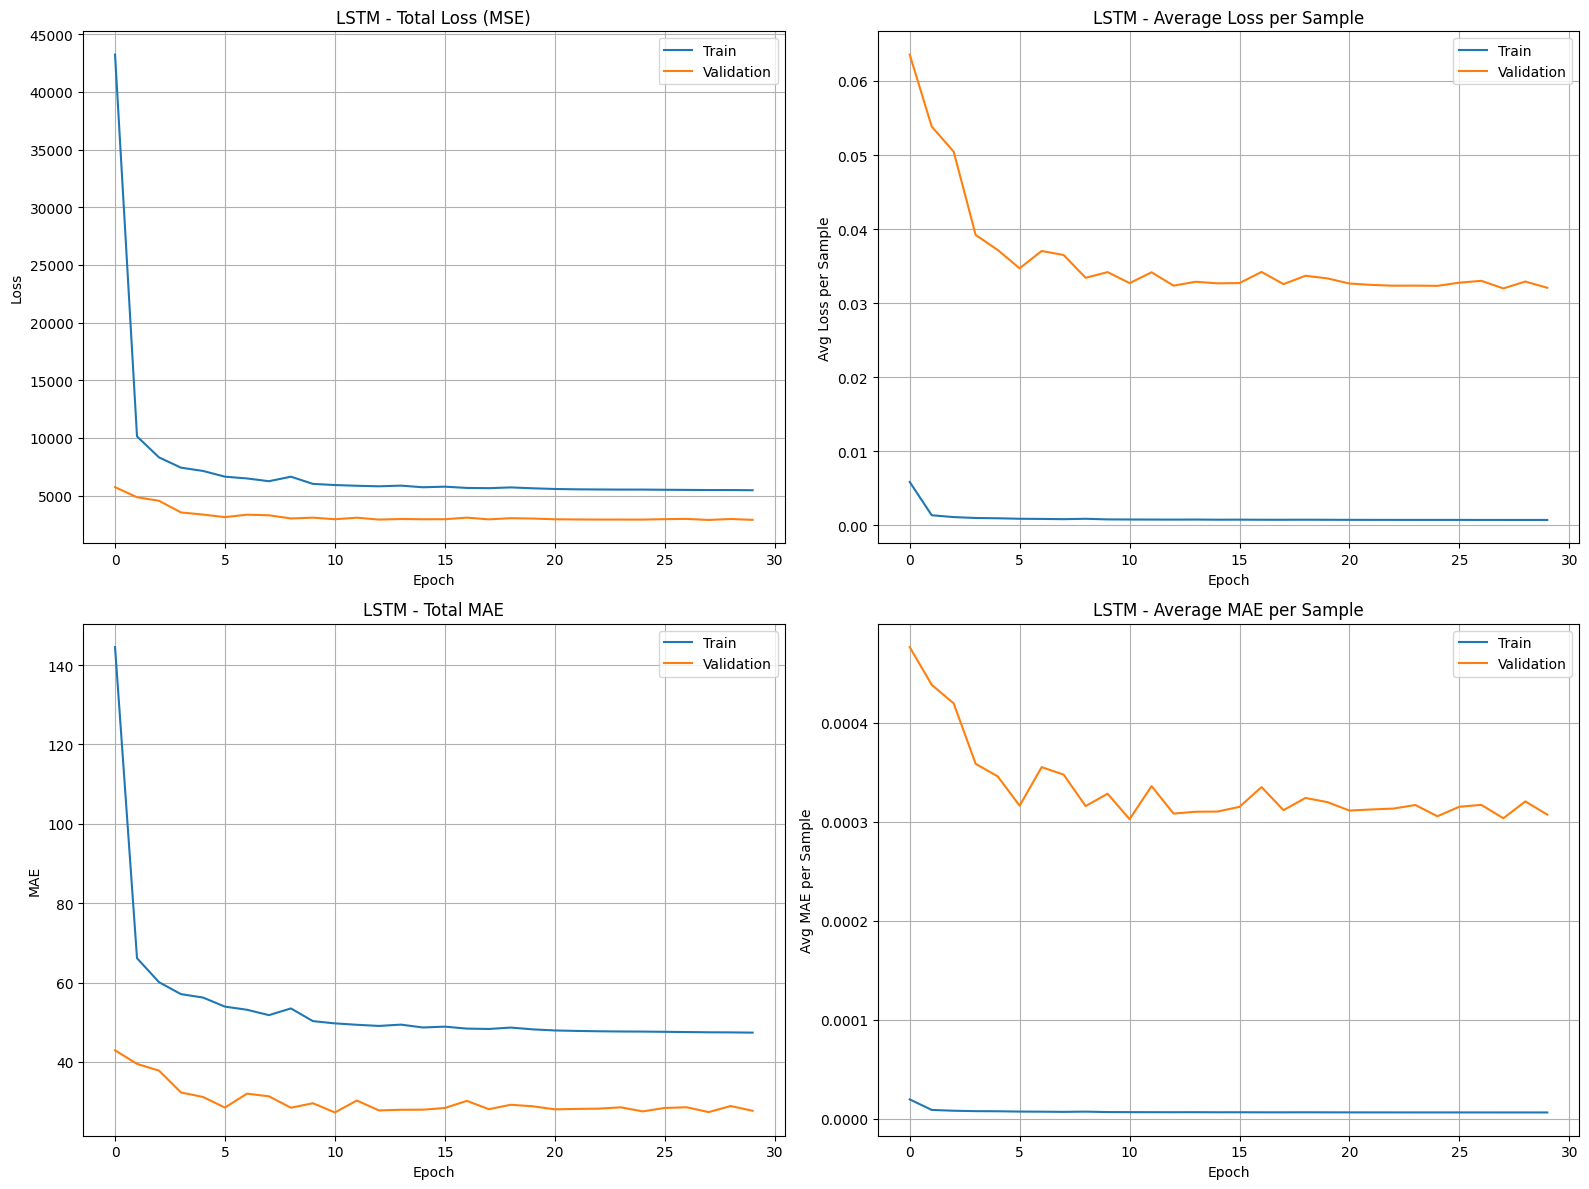


Evaluating LSTM model on test set...

LSTM - Test Evaluation Metrics:
  Overall:  MSE: 2826.12, RMSE: 53.16, MAE: 27.74, R²: 0.9707, WAPE: 11.99%
  Daytime:  MSE: 5637.30, RMSE: 75.08, MAE: 50.07, R²: 0.9342, WAPE: 10.79%
  Nighttime: MSE: 32.60, RMSE: 5.71, MAE: 5.56, R²: -12.0125, WAPE: 1796.39%
  Inference Speed: 7675191.33 samples/sec, 0.0001 ms/sample
  Total time: 0.0117 sec for 90112 samples
Model saved to checkpoints/LSTM_best_20250430_162144.pt with metadata.
Best model saved to checkpoints/LSTM_best_20250430_162144.pt
Saved model checkpoint logged to wandb: checkpoints/LSTM_best_20250430_162144.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/learning_rate,██████████████████▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


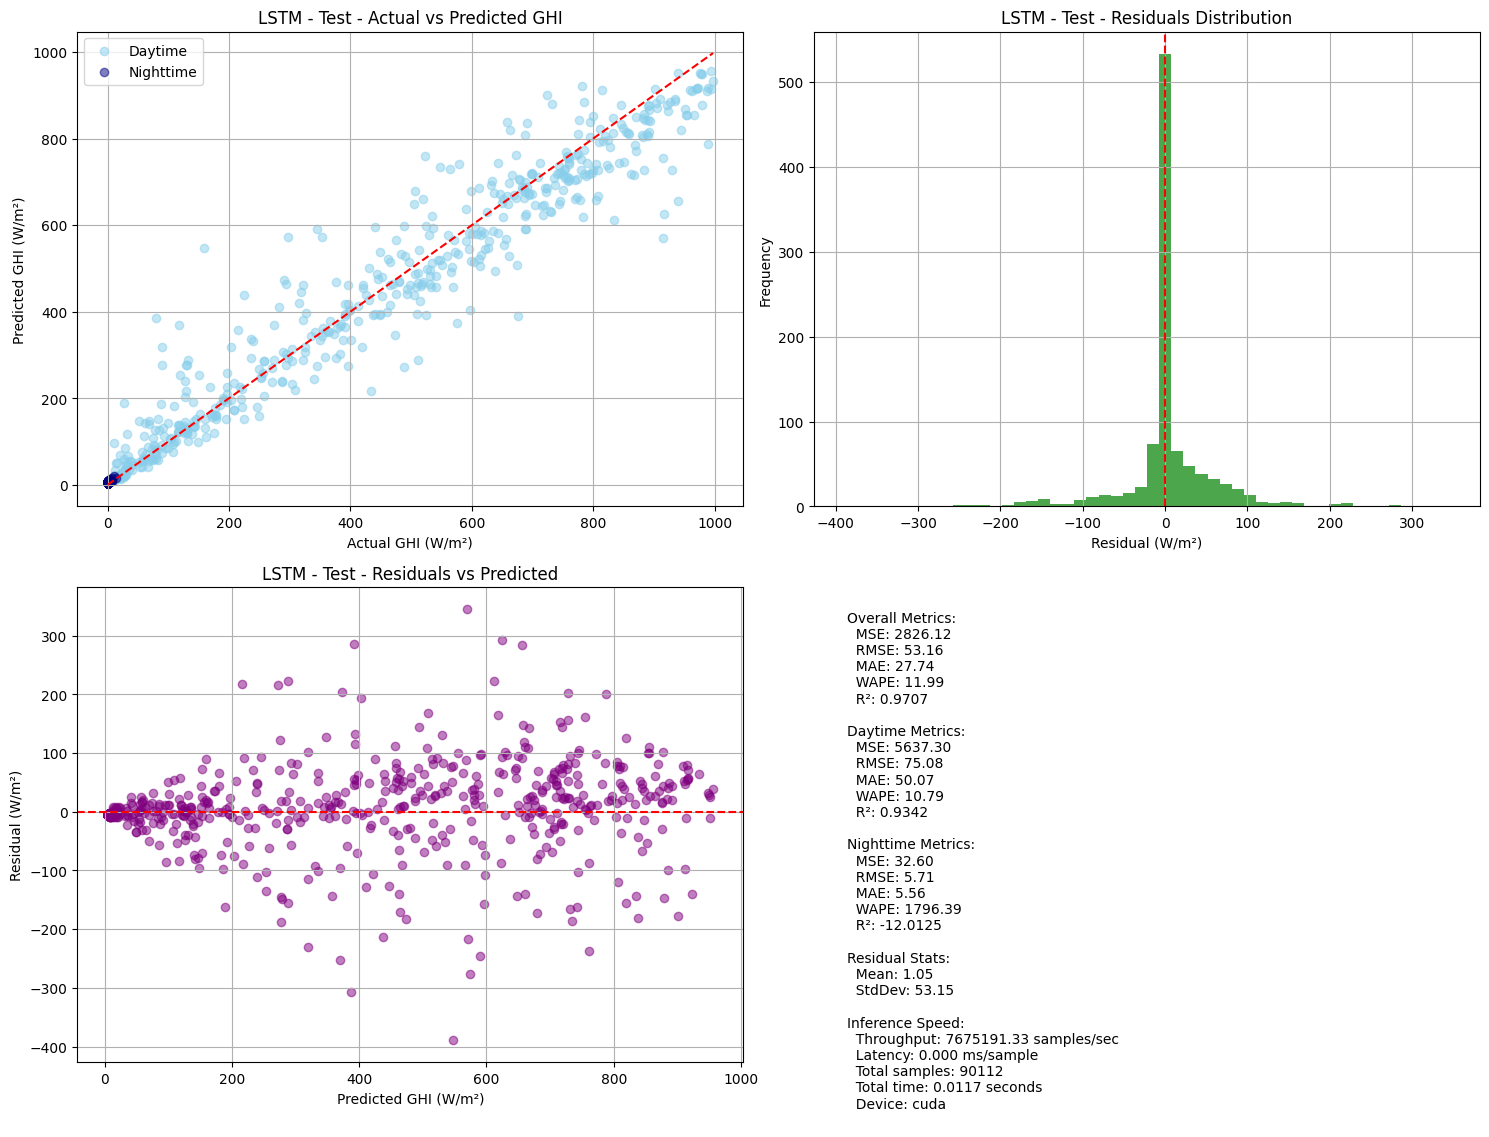

In [8]:
model_name = "LSTM"

# Train the LSTM model
lstm_history, lstm_val_metrics, lstm_test_metrics = run_experiment_pipeline(
    lstm_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.2 CNN-LSTM Model

In [9]:
from models.cnn_lstm import CNNLSTMModel

# Create CNN-LSTM model
cnn_lstm_model = CNNLSTMModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dim=128,
    num_filters=64,
    kernel_size=3,
    num_layers=2,
    dropout=0.3
).to(device)

# Print the model
print_model_info(cnn_lstm_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: CNNLSTMModel
Total parameters: 306,049
Trainable parameters: 306,049
Non-trainable parameters: 0

Model structure:
CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (static_proj): Sequential(
    

Training CNN-LSTM model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for CNN-LSTM


Training config: {'PATIENCE': 10, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 


Validation CNN-LSTM (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4650.08, RMSE: 68.19, MAE: 44.29, R²: 0.9519, WAPE: 18.97%
  Daytime:  MSE: 8633.77, RMSE: 92.92, MAE: 66.11, R²: 0.8973, WAPE: 14.12%
  Nighttime: MSE: 689.83, RMSE: 26.26, MAE: 22.61, R²: -266.3278, WAPE: 7154.21%
  Inference Speed: 3525259.03 samples/sec, 0.0003 ms/sample
  Total time: 0.0256 sec for 90112 samples
Epoch 1/30 | Train Loss: 57176.7266, Train MAE: 159.4229 | Val Loss: 4650.0771, Val MAE: 44.2914 | LR: 0.000100



Validation CNN-LSTM (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3533.71, RMSE: 59.44, MAE: 34.93, R²: 0.9634, WAPE: 14.96%
  Daytime:  MSE: 6860.65, RMSE: 82.83, MAE: 56.42, R²: 0.9184, WAPE: 12.06%
  Nighttime: MSE: 226.35, RMSE: 15.04, MAE: 13.57, R²: -86.7160, WAPE: 4293.46%
  Inference Speed: 7183448.11 samples/sec, 0.0001 ms/sample
  Total time: 0.0125 sec for 90112 samples
Epoch 2/30 | Train Loss: 11147.9375, Train MAE: 67.9565 | Val Loss: 3533.7070, Val MAE: 34.9322 | LR: 0.000100



Validation CNN-LSTM (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3275.59, RMSE: 57.23, MAE: 29.88, R²: 0.9661, WAPE: 12.80%
  Daytime:  MSE: 6555.45, RMSE: 80.97, MAE: 56.93, R²: 0.9220, WAPE: 12.16%
  Nighttime: MSE: 15.04, RMSE: 3.88, MAE: 2.99, R²: -4.8280, WAPE: 945.71%
  Inference Speed: 5764529.21 samples/sec, 0.0002 ms/sample
  Total time: 0.0156 sec for 90112 samples
Epoch 3/30 | Train Loss: 8337.5322, Train MAE: 54.4193 | Val Loss: 3275.5906, Val MAE: 29.8787 | LR: 0.000100



Validation CNN-LSTM (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3197.30, RMSE: 56.54, MAE: 31.79, R²: 0.9669, WAPE: 13.61%
  Daytime:  MSE: 6336.93, RMSE: 79.60, MAE: 55.48, R²: 0.9246, WAPE: 11.85%
  Nighttime: MSE: 76.15, RMSE: 8.73, MAE: 8.24, R²: -28.5090, WAPE: 2606.75%
  Inference Speed: 5531025.87 samples/sec, 0.0002 ms/sample
  Total time: 0.0163 sec for 90112 samples
Epoch 4/30 | Train Loss: 7317.7368, Train MAE: 49.4557 | Val Loss: 3197.2979, Val MAE: 31.7881 | LR: 0.000100



Validation CNN-LSTM (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3262.10, RMSE: 57.11, MAE: 34.06, R²: 0.9662, WAPE: 14.59%
  Daytime:  MSE: 6365.83, RMSE: 79.79, MAE: 56.01, R²: 0.9242, WAPE: 11.97%
  Nighttime: MSE: 176.64, RMSE: 13.29, MAE: 12.24, R²: -67.4510, WAPE: 3873.38%
  Inference Speed: 6212108.77 samples/sec, 0.0002 ms/sample
  Total time: 0.0145 sec for 90112 samples
Epoch 5/30 | Train Loss: 6792.4292, Train MAE: 48.0832 | Val Loss: 3262.0986, Val MAE: 34.0577 | LR: 0.000100



Validation CNN-LSTM (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3100.90, RMSE: 55.69, MAE: 29.72, R²: 0.9679, WAPE: 12.73%
  Daytime:  MSE: 6169.97, RMSE: 78.55, MAE: 54.34, R²: 0.9266, WAPE: 11.61%
  Nighttime: MSE: 49.90, RMSE: 7.06, MAE: 5.24, R²: -18.3391, WAPE: 1659.84%
  Inference Speed: 5661770.06 samples/sec, 0.0002 ms/sample
  Total time: 0.0159 sec for 90112 samples
Epoch 6/30 | Train Loss: 6416.9702, Train MAE: 47.3274 | Val Loss: 3100.9031, Val MAE: 29.7193 | LR: 0.000100



Validation CNN-LSTM (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3023.06, RMSE: 54.98, MAE: 27.87, R²: 0.9687, WAPE: 11.94%
  Daytime:  MSE: 6048.72, RMSE: 77.77, MAE: 53.29, R²: 0.9280, WAPE: 11.38%
  Nighttime: MSE: 15.21, RMSE: 3.90, MAE: 2.60, R²: -4.8925, WAPE: 824.15%
  Inference Speed: 6343478.27 samples/sec, 0.0002 ms/sample
  Total time: 0.0142 sec for 90112 samples
Epoch 7/30 | Train Loss: 6076.5825, Train MAE: 46.4773 | Val Loss: 3023.0579, Val MAE: 27.8702 | LR: 0.000100



Validation CNN-LSTM (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 2931.76, RMSE: 54.15, MAE: 26.08, R²: 0.9696, WAPE: 11.17%
  Daytime:  MSE: 5875.17, RMSE: 76.65, MAE: 50.38, R²: 0.9301, WAPE: 10.76%
  Nighttime: MSE: 5.69, RMSE: 2.39, MAE: 1.93, R²: -1.2045, WAPE: 609.48%
  Inference Speed: 7077583.65 samples/sec, 0.0001 ms/sample
  Total time: 0.0127 sec for 90112 samples
Epoch 8/30 | Train Loss: 5845.2969, Train MAE: 46.1054 | Val Loss: 2931.7646, Val MAE: 26.0797 | LR: 0.000100



Validation CNN-LSTM (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3028.47, RMSE: 55.03, MAE: 28.57, R²: 0.9686, WAPE: 12.24%
  Daytime:  MSE: 6056.61, RMSE: 77.82, MAE: 53.17, R²: 0.9279, WAPE: 11.36%
  Nighttime: MSE: 18.16, RMSE: 4.26, MAE: 4.12, R²: -6.0363, WAPE: 1304.21%
  Inference Speed: 4432890.64 samples/sec, 0.0002 ms/sample
  Total time: 0.0203 sec for 90112 samples
Epoch 9/30 | Train Loss: 5676.1084, Train MAE: 45.9737 | Val Loss: 3028.4697, Val MAE: 28.5745 | LR: 0.000100



Validation CNN-LSTM (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2981.58, RMSE: 54.60, MAE: 27.65, R²: 0.9691, WAPE: 11.84%
  Daytime:  MSE: 5964.96, RMSE: 77.23, MAE: 51.64, R²: 0.9290, WAPE: 11.03%
  Nighttime: MSE: 15.77, RMSE: 3.97, MAE: 3.80, R²: -5.1112, WAPE: 1202.73%
  Inference Speed: 6117592.86 samples/sec, 0.0002 ms/sample
  Total time: 0.0147 sec for 90112 samples
Epoch 10/30 | Train Loss: 5583.9009, Train MAE: 46.0479 | Val Loss: 2981.5842, Val MAE: 27.6478 | LR: 0.000100



Validation CNN-LSTM (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2916.69, RMSE: 54.01, MAE: 28.07, R²: 0.9698, WAPE: 12.02%
  Daytime:  MSE: 5805.38, RMSE: 76.19, MAE: 49.61, R²: 0.9309, WAPE: 10.60%
  Nighttime: MSE: 45.00, RMSE: 6.71, MAE: 6.65, R²: -16.4398, WAPE: 2104.61%
  Inference Speed: 7573835.68 samples/sec, 0.0001 ms/sample
  Total time: 0.0119 sec for 90112 samples
Epoch 11/30 | Train Loss: 5555.6270, Train MAE: 46.3032 | Val Loss: 2916.6917, Val MAE: 28.0658 | LR: 0.000100



Validation CNN-LSTM (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2933.50, RMSE: 54.16, MAE: 27.90, R²: 0.9696, WAPE: 11.95%
  Daytime:  MSE: 5857.20, RMSE: 76.53, MAE: 50.80, R²: 0.9303, WAPE: 10.85%
  Nighttime: MSE: 27.01, RMSE: 5.20, MAE: 5.14, R²: -9.4687, WAPE: 1627.33%
  Inference Speed: 7705704.95 samples/sec, 0.0001 ms/sample
  Total time: 0.0117 sec for 90112 samples
Epoch 12/30 | Train Loss: 5472.8208, Train MAE: 46.0042 | Val Loss: 2933.5029, Val MAE: 27.9029 | LR: 0.000100



Validation CNN-LSTM (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2923.78, RMSE: 54.07, MAE: 26.34, R²: 0.9697, WAPE: 11.28%
  Daytime:  MSE: 5852.46, RMSE: 76.50, MAE: 49.37, R²: 0.9304, WAPE: 10.55%
  Nighttime: MSE: 12.34, RMSE: 3.51, MAE: 3.44, R²: -3.7824, WAPE: 1088.56%
  Inference Speed: 5929111.19 samples/sec, 0.0002 ms/sample
  Total time: 0.0152 sec for 90112 samples
Epoch 13/30 | Train Loss: 5446.7700, Train MAE: 45.9999 | Val Loss: 2923.7791, Val MAE: 26.3389 | LR: 0.000100



Validation CNN-LSTM (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2907.97, RMSE: 53.93, MAE: 27.60, R²: 0.9699, WAPE: 11.82%
  Daytime:  MSE: 5800.06, RMSE: 76.16, MAE: 49.65, R²: 0.9310, WAPE: 10.61%
  Nighttime: MSE: 32.90, RMSE: 5.74, MAE: 5.68, R²: -11.7491, WAPE: 1798.47%
  Inference Speed: 5784998.96 samples/sec, 0.0002 ms/sample
  Total time: 0.0156 sec for 90112 samples
Epoch 14/30 | Train Loss: 5411.1006, Train MAE: 45.9455 | Val Loss: 2907.9673, Val MAE: 27.6027 | LR: 0.000100



Validation CNN-LSTM (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2897.53, RMSE: 53.83, MAE: 27.10, R²: 0.9700, WAPE: 11.61%
  Daytime:  MSE: 5787.58, RMSE: 76.08, MAE: 49.43, R²: 0.9311, WAPE: 10.56%
  Nighttime: MSE: 24.49, RMSE: 4.95, MAE: 4.90, R²: -8.4917, WAPE: 1550.20%
  Inference Speed: 7104056.58 samples/sec, 0.0001 ms/sample
  Total time: 0.0127 sec for 90112 samples
Epoch 15/30 | Train Loss: 5389.9111, Train MAE: 45.9896 | Val Loss: 2897.5281, Val MAE: 27.0972 | LR: 0.000100



Validation CNN-LSTM (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2949.77, RMSE: 54.31, MAE: 28.32, R²: 0.9695, WAPE: 12.13%
  Daytime:  MSE: 5879.60, RMSE: 76.68, MAE: 50.72, R²: 0.9300, WAPE: 10.84%
  Nighttime: MSE: 37.18, RMSE: 6.10, MAE: 6.04, R²: -13.4093, WAPE: 1913.00%
  Inference Speed: 6479079.83 samples/sec, 0.0002 ms/sample
  Total time: 0.0139 sec for 90112 samples
Epoch 16/30 | Train Loss: 5360.5703, Train MAE: 45.8804 | Val Loss: 2949.7698, Val MAE: 28.3168 | LR: 0.000100



Validation CNN-LSTM (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2961.00, RMSE: 54.42, MAE: 27.92, R²: 0.9693, WAPE: 11.96%
  Daytime:  MSE: 5906.52, RMSE: 76.85, MAE: 50.53, R²: 0.9297, WAPE: 10.80%
  Nighttime: MSE: 32.81, RMSE: 5.73, MAE: 5.44, R²: -11.7167, WAPE: 1722.43%
  Inference Speed: 7809676.88 samples/sec, 0.0001 ms/sample
  Total time: 0.0115 sec for 90112 samples
Epoch 17/30 | Train Loss: 5359.0864, Train MAE: 45.9215 | Val Loss: 2960.9983, Val MAE: 27.9206 | LR: 0.000100



Validation CNN-LSTM (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2938.08, RMSE: 54.20, MAE: 27.73, R²: 0.9696, WAPE: 11.88%
  Daytime:  MSE: 5857.38, RMSE: 76.53, MAE: 49.64, R²: 0.9303, WAPE: 10.61%
  Nighttime: MSE: 35.96, RMSE: 6.00, MAE: 5.94, R²: -12.9357, WAPE: 1881.11%
  Inference Speed: 7131804.70 samples/sec, 0.0001 ms/sample
  Total time: 0.0126 sec for 90112 samples
Epoch 18/30 | Train Loss: 5318.3467, Train MAE: 45.7094 | Val Loss: 2938.0784, Val MAE: 27.7274 | LR: 0.000100



Validation CNN-LSTM (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2917.14, RMSE: 54.01, MAE: 27.68, R²: 0.9698, WAPE: 11.86%
  Daytime:  MSE: 5817.10, RMSE: 76.27, MAE: 49.68, R²: 0.9308, WAPE: 10.62%
  Nighttime: MSE: 34.25, RMSE: 5.85, MAE: 5.81, R²: -12.2711, WAPE: 1837.12%
  Inference Speed: 6482858.31 samples/sec, 0.0002 ms/sample
  Total time: 0.0139 sec for 90112 samples
Epoch 19/30 | Train Loss: 5300.2324, Train MAE: 45.6240 | Val Loss: 2917.1404, Val MAE: 27.6798 | LR: 0.000100



Validation CNN-LSTM (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2967.04, RMSE: 54.47, MAE: 28.42, R²: 0.9693, WAPE: 12.17%
  Daytime:  MSE: 5911.92, RMSE: 76.89, MAE: 50.73, R²: 0.9296, WAPE: 10.84%
  Nighttime: MSE: 39.50, RMSE: 6.28, MAE: 6.23, R²: -14.3067, WAPE: 1972.61%
  Inference Speed: 8286171.09 samples/sec, 0.0001 ms/sample
  Total time: 0.0109 sec for 90112 samples
Epoch 20/30 | Train Loss: 5289.3428, Train MAE: 45.6409 | Val Loss: 2967.0439, Val MAE: 28.4152 | LR: 0.000100



Validation CNN-LSTM (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 3066.40, RMSE: 55.38, MAE: 28.67, R²: 0.9683, WAPE: 12.28%
  Daytime:  MSE: 6127.31, RMSE: 78.28, MAE: 52.68, R²: 0.9271, WAPE: 11.26%
  Nighttime: MSE: 23.50, RMSE: 4.85, MAE: 4.80, R²: -8.1067, WAPE: 1519.95%
  Inference Speed: 6623970.31 samples/sec, 0.0002 ms/sample
  Total time: 0.0136 sec for 90112 samples
Epoch 21/30 | Train Loss: 5250.5063, Train MAE: 45.4725 | Val Loss: 3066.3977, Val MAE: 28.6727 | LR: 0.000050



Validation CNN-LSTM (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2959.02, RMSE: 54.40, MAE: 27.85, R²: 0.9694, WAPE: 11.93%
  Daytime:  MSE: 5904.08, RMSE: 76.84, MAE: 50.29, R²: 0.9297, WAPE: 10.75%
  Nighttime: MSE: 31.29, RMSE: 5.59, MAE: 5.55, R²: -11.1276, WAPE: 1755.44%
  Inference Speed: 5048111.04 samples/sec, 0.0002 ms/sample
  Total time: 0.0179 sec for 90112 samples
Epoch 22/30 | Train Loss: 5212.9521, Train MAE: 45.2797 | Val Loss: 2959.0212, Val MAE: 27.8541 | LR: 0.000050



Validation CNN-LSTM (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2984.40, RMSE: 54.63, MAE: 28.04, R²: 0.9691, WAPE: 12.01%
  Daytime:  MSE: 5955.37, RMSE: 77.17, MAE: 51.00, R²: 0.9291, WAPE: 10.90%
  Nighttime: MSE: 30.92, RMSE: 5.56, MAE: 5.20, R²: -10.9839, WAPE: 1647.11%
  Inference Speed: 7217054.08 samples/sec, 0.0001 ms/sample
  Total time: 0.0125 sec for 90112 samples
Epoch 23/30 | Train Loss: 5192.8423, Train MAE: 45.2426 | Val Loss: 2984.4023, Val MAE: 28.0371 | LR: 0.000050



Validation CNN-LSTM (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 3003.00, RMSE: 54.80, MAE: 28.86, R²: 0.9689, WAPE: 12.36%
  Daytime:  MSE: 5972.95, RMSE: 77.28, MAE: 51.09, R²: 0.9289, WAPE: 10.92%
  Nighttime: MSE: 50.53, RMSE: 7.11, MAE: 6.75, R²: -18.5802, WAPE: 2137.52%
  Inference Speed: 6112547.05 samples/sec, 0.0002 ms/sample
  Total time: 0.0147 sec for 90112 samples
Epoch 24/30 | Train Loss: 5178.8813, Train MAE: 45.2259 | Val Loss: 3002.9985, Val MAE: 28.8586 | LR: 0.000050



Validation CNN-LSTM (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2974.91, RMSE: 54.54, MAE: 27.51, R²: 0.9692, WAPE: 11.78%
  Daytime:  MSE: 5944.09, RMSE: 77.10, MAE: 50.38, R²: 0.9293, WAPE: 10.76%
  Nighttime: MSE: 23.20, RMSE: 4.82, MAE: 4.77, R²: -7.9903, WAPE: 1510.29%
  Inference Speed: 8263525.34 samples/sec, 0.0001 ms/sample
  Total time: 0.0109 sec for 90112 samples
Epoch 25/30 | Train Loss: 5164.9814, Train MAE: 45.1739 | Val Loss: 2974.9062, Val MAE: 27.5075 | LR: 0.000050
Early stopping at epoch 25
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


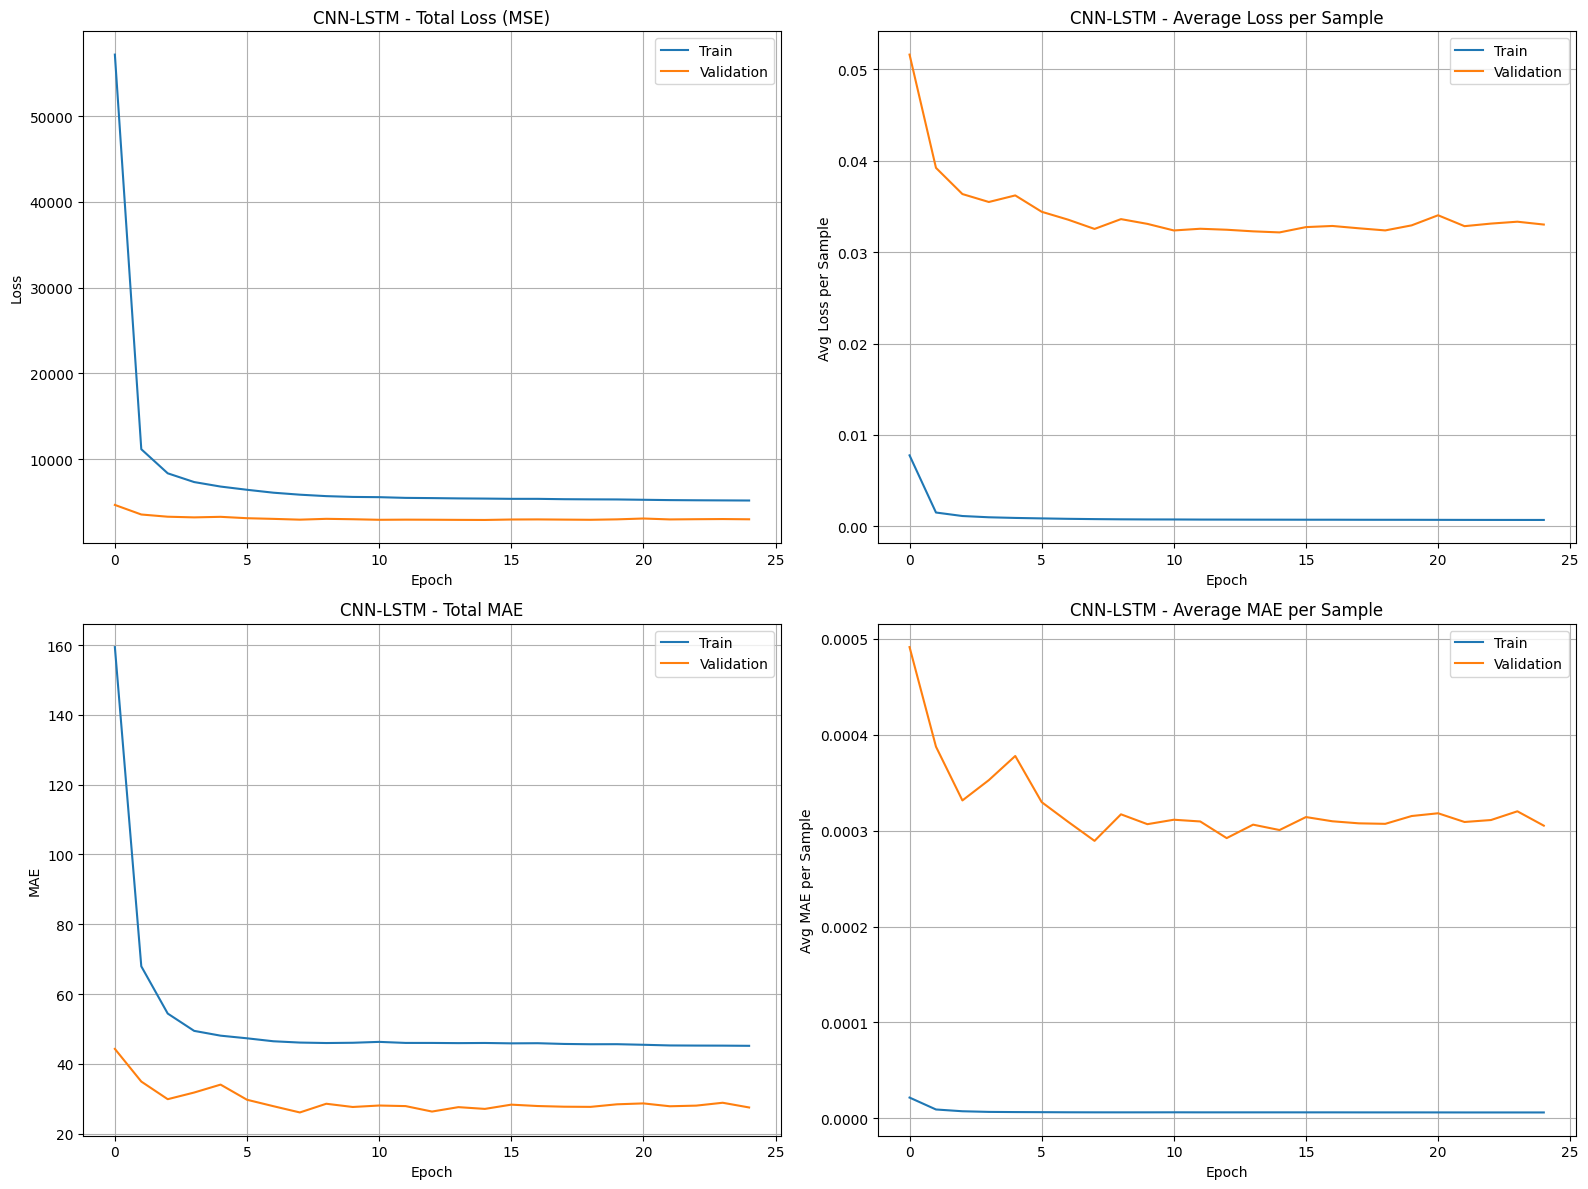


Evaluating CNN-LSTM model on test set...

CNN-LSTM - Test Evaluation Metrics:
  Overall:  MSE: 2900.39, RMSE: 53.86, MAE: 27.59, R²: 0.9699, WAPE: 11.93%
  Daytime:  MSE: 5795.57, RMSE: 76.13, MAE: 50.53, R²: 0.9323, WAPE: 10.89%
  Nighttime: MSE: 23.41, RMSE: 4.84, MAE: 4.80, R²: -8.3429, WAPE: 1549.37%
  Inference Speed: 6121754.49 samples/sec, 0.0002 ms/sample
  Total time: 0.0147 sec for 90112 samples
Model saved to checkpoints/CNN-LSTM_best_20250430_170837.pt with metadata.
Best model saved to checkpoints/CNN-LSTM_best_20250430_170837.pt
Saved model checkpoint logged to wandb: checkpoints/CNN-LSTM_best_20250430_170837.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/learning_rate,████████████████████▁▁▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


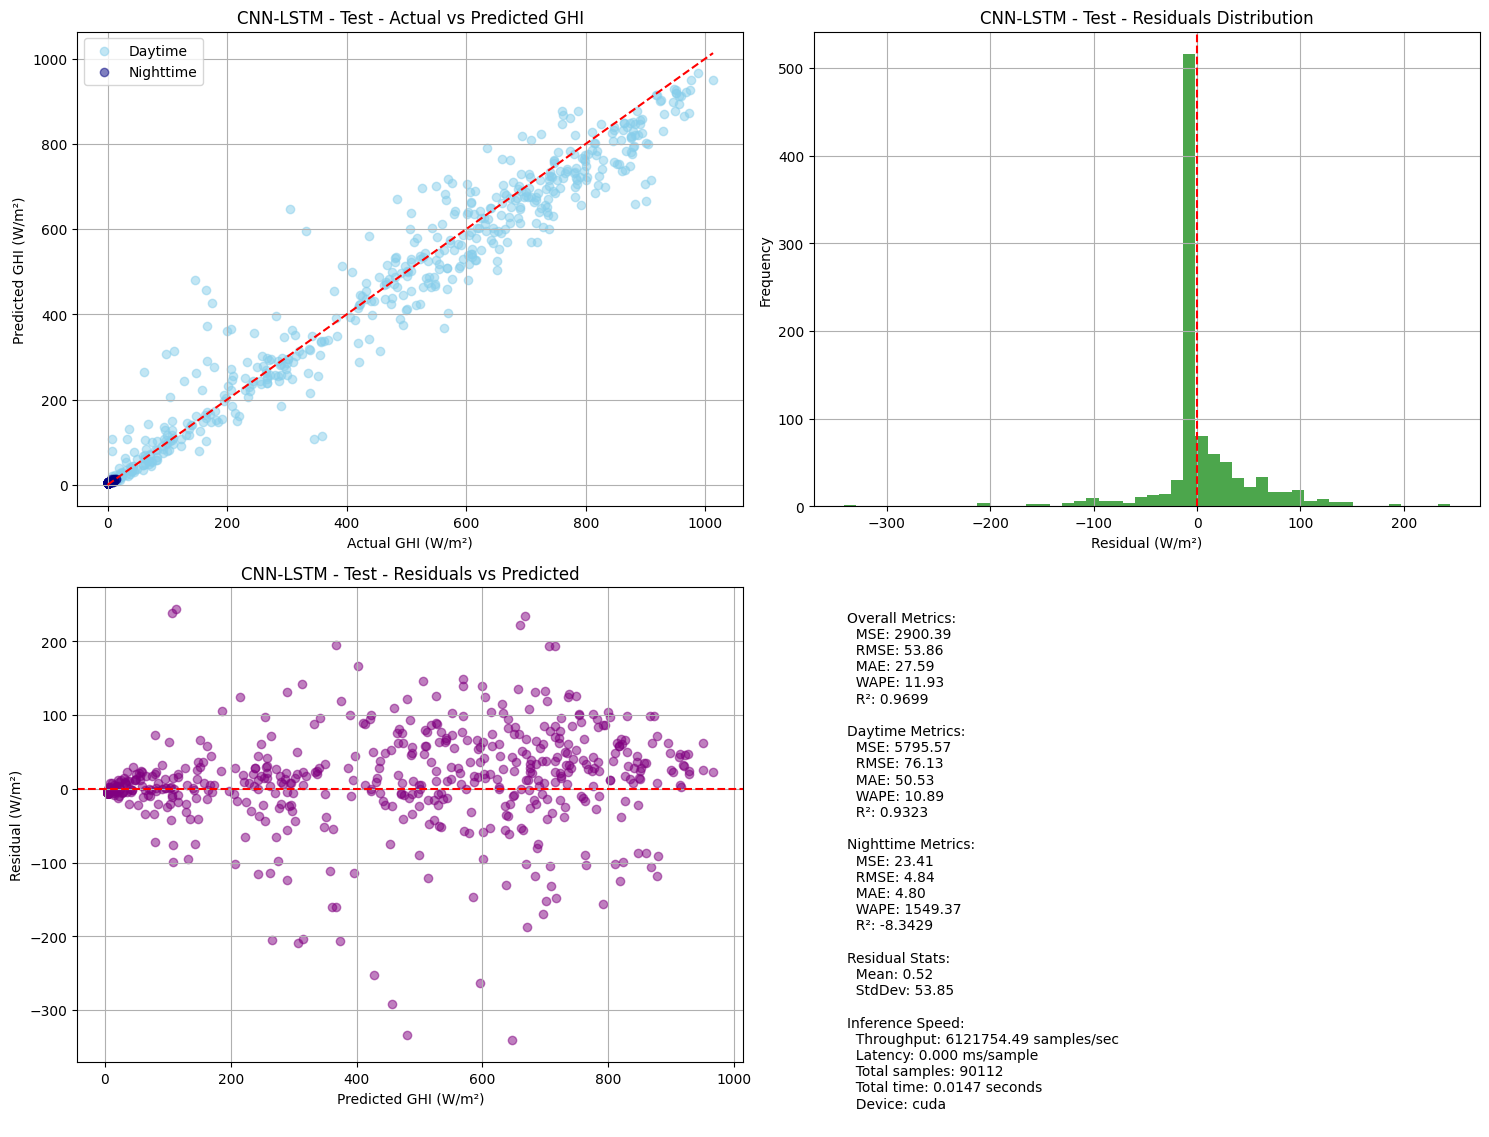

In [10]:
model_name = "CNN-LSTM"

# Train the LSTM model
cnn_lstm_history, cnn_lstm_val_metrics, cnn_lstm_test_metrics = run_experiment_pipeline(
    cnn_lstm_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.3 Multi-Layer Perceptron (MLP) Model

In [11]:
from models.mlp import MLPModel

# Create MLP model
mlp_model = MLPModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dims=[256, 512, 256, 128],
    dropout=0.3,
    lookback=LOOKBACK
).to(device)

# Print the model
print_model_info(mlp_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: MLPModel
Total parameters: 425,793
Trainable parameters: 425,793
Non-trainable parameters: 0

Model structure:
MLPModel(
  (mlp): Sequential(
    (0): Linear(in_features=456, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, mom

Training MLP model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for MLP


Training config: {'PATIENCE': 10, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 


Validation MLP (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4830.27, RMSE: 69.50, MAE: 45.08, R²: 0.9500, WAPE: 19.31%
  Daytime:  MSE: 9035.45, RMSE: 95.05, MAE: 68.66, R²: 0.8925, WAPE: 14.67%
  Nighttime: MSE: 649.85, RMSE: 25.49, MAE: 21.64, R²: -250.8353, WAPE: 6849.72%
  Inference Speed: 15335434.64 samples/sec, 0.0001 ms/sample
  Total time: 0.0059 sec for 90112 samples
Epoch 1/30 | Train Loss: 45318.2109, Train MAE: 151.6315 | Val Loss: 4830.2729, Val MAE: 45.0810 | LR: 0.000100



Validation MLP (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3855.90, RMSE: 62.10, MAE: 39.29, R²: 0.9601, WAPE: 16.83%
  Daytime:  MSE: 7334.40, RMSE: 85.64, MAE: 62.46, R²: 0.9127, WAPE: 13.35%
  Nighttime: MSE: 397.88, RMSE: 19.95, MAE: 16.26, R²: -153.1900, WAPE: 5146.29%
  Inference Speed: 16040960.96 samples/sec, 0.0001 ms/sample
  Total time: 0.0056 sec for 90112 samples
Epoch 2/30 | Train Loss: 10030.4238, Train MAE: 72.1047 | Val Loss: 3855.9009, Val MAE: 39.2929 | LR: 0.000100



Validation MLP (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3991.88, RMSE: 63.18, MAE: 40.86, R²: 0.9587, WAPE: 17.50%
  Daytime:  MSE: 7642.13, RMSE: 87.42, MAE: 65.73, R²: 0.9091, WAPE: 14.04%
  Nighttime: MSE: 363.11, RMSE: 19.06, MAE: 16.13, R²: -139.7152, WAPE: 5105.30%
  Inference Speed: 14802111.77 samples/sec, 0.0001 ms/sample
  Total time: 0.0061 sec for 90112 samples
Epoch 3/30 | Train Loss: 7095.3989, Train MAE: 57.1270 | Val Loss: 3991.8767, Val MAE: 40.8573 | LR: 0.000100



Validation MLP (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3125.16, RMSE: 55.90, MAE: 33.12, R²: 0.9676, WAPE: 14.19%
  Daytime:  MSE: 6077.79, RMSE: 77.96, MAE: 53.68, R²: 0.9277, WAPE: 11.47%
  Nighttime: MSE: 189.91, RMSE: 13.78, MAE: 12.69, R²: -72.5932, WAPE: 4015.79%
  Inference Speed: 16172056.05 samples/sec, 0.0001 ms/sample
  Total time: 0.0056 sec for 90112 samples
Epoch 4/30 | Train Loss: 6021.1865, Train MAE: 50.5267 | Val Loss: 3125.1584, Val MAE: 33.1219 | LR: 0.000100



Validation MLP (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3115.31, RMSE: 55.81, MAE: 30.54, R²: 0.9677, WAPE: 13.08%
  Daytime:  MSE: 6207.02, RMSE: 78.78, MAE: 55.49, R²: 0.9261, WAPE: 11.86%
  Nighttime: MSE: 41.79, RMSE: 6.46, MAE: 5.74, R²: -15.1953, WAPE: 1817.99%
  Inference Speed: 21009289.72 samples/sec, 0.0000 ms/sample
  Total time: 0.0043 sec for 90112 samples
Epoch 5/30 | Train Loss: 5440.7246, Train MAE: 46.7524 | Val Loss: 3115.3071, Val MAE: 30.5423 | LR: 0.000100



Validation MLP (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 2922.17, RMSE: 54.06, MAE: 26.35, R²: 0.9697, WAPE: 11.29%
  Daytime:  MSE: 5848.95, RMSE: 76.48, MAE: 50.50, R²: 0.9304, WAPE: 10.79%
  Nighttime: MSE: 12.62, RMSE: 3.55, MAE: 2.34, R²: -3.8914, WAPE: 741.03%
  Inference Speed: 13796069.57 samples/sec, 0.0001 ms/sample
  Total time: 0.0065 sec for 90112 samples
Epoch 6/30 | Train Loss: 5117.6138, Train MAE: 44.6587 | Val Loss: 2922.1702, Val MAE: 26.3492 | LR: 0.000100



Validation MLP (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 2876.06, RMSE: 53.63, MAE: 25.35, R²: 0.9702, WAPE: 10.86%
  Daytime:  MSE: 5763.27, RMSE: 75.92, MAE: 49.71, R²: 0.9314, WAPE: 10.62%
  Nighttime: MSE: 5.84, RMSE: 2.42, MAE: 1.14, R²: -1.2642, WAPE: 359.96%
  Inference Speed: 18793551.89 samples/sec, 0.0001 ms/sample
  Total time: 0.0048 sec for 90112 samples
Epoch 7/30 | Train Loss: 4911.1094, Train MAE: 43.4781 | Val Loss: 2876.0593, Val MAE: 25.3517 | LR: 0.000100



Validation MLP (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3071.32, RMSE: 55.42, MAE: 27.72, R²: 0.9682, WAPE: 11.87%
  Daytime:  MSE: 6155.96, RMSE: 78.46, MAE: 54.23, R²: 0.9267, WAPE: 11.59%
  Nighttime: MSE: 4.83, RMSE: 2.20, MAE: 1.36, R²: -0.8713, WAPE: 430.81%
  Inference Speed: 11101040.39 samples/sec, 0.0001 ms/sample
  Total time: 0.0081 sec for 90112 samples
Epoch 8/30 | Train Loss: 4779.6489, Train MAE: 42.7732 | Val Loss: 3071.3186, Val MAE: 27.7155 | LR: 0.000100



Validation MLP (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2864.02, RMSE: 53.52, MAE: 25.52, R²: 0.9703, WAPE: 10.93%
  Daytime:  MSE: 5742.06, RMSE: 75.78, MAE: 50.26, R²: 0.9317, WAPE: 10.74%
  Nighttime: MSE: 2.93, RMSE: 1.71, MAE: 0.92, R²: -0.1340, WAPE: 291.36%
  Inference Speed: 12067981.80 samples/sec, 0.0001 ms/sample
  Total time: 0.0075 sec for 90112 samples
Epoch 9/30 | Train Loss: 4666.0723, Train MAE: 42.2160 | Val Loss: 2864.0217, Val MAE: 25.5199 | LR: 0.000100



Validation MLP (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3066.11, RMSE: 55.37, MAE: 27.54, R²: 0.9683, WAPE: 11.80%
  Daytime:  MSE: 6145.68, RMSE: 78.39, MAE: 53.70, R²: 0.9269, WAPE: 11.47%
  Nighttime: MSE: 4.67, RMSE: 2.16, MAE: 1.53, R²: -0.8109, WAPE: 485.74%
  Inference Speed: 14899559.35 samples/sec, 0.0001 ms/sample
  Total time: 0.0060 sec for 90112 samples
Epoch 10/30 | Train Loss: 4569.2002, Train MAE: 41.7729 | Val Loss: 3066.1116, Val MAE: 27.5428 | LR: 0.000100



Validation MLP (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3288.21, RMSE: 57.34, MAE: 29.25, R²: 0.9660, WAPE: 12.53%
  Daytime:  MSE: 6593.59, RMSE: 81.20, MAE: 57.92, R²: 0.9215, WAPE: 12.37%
  Nighttime: MSE: 2.28, RMSE: 1.51, MAE: 0.76, R²: 0.1181, WAPE: 239.95%
  Inference Speed: 15707635.36 samples/sec, 0.0001 ms/sample
  Total time: 0.0057 sec for 90112 samples
Epoch 11/30 | Train Loss: 4499.9854, Train MAE: 41.4631 | Val Loss: 3288.2068, Val MAE: 29.2540 | LR: 0.000100



Validation MLP (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3220.24, RMSE: 56.75, MAE: 29.37, R²: 0.9667, WAPE: 12.58%
  Daytime:  MSE: 6452.01, RMSE: 80.32, MAE: 56.36, R²: 0.9232, WAPE: 12.04%
  Nighttime: MSE: 7.51, RMSE: 2.74, MAE: 2.54, R²: -1.9084, WAPE: 804.37%
  Inference Speed: 18995683.87 samples/sec, 0.0001 ms/sample
  Total time: 0.0047 sec for 90112 samples
Epoch 12/30 | Train Loss: 4446.5161, Train MAE: 41.2764 | Val Loss: 3220.2439, Val MAE: 29.3696 | LR: 0.000100



Validation MLP (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3081.32, RMSE: 55.51, MAE: 27.87, R²: 0.9681, WAPE: 11.94%
  Daytime:  MSE: 6176.00, RMSE: 78.59, MAE: 54.07, R²: 0.9265, WAPE: 11.55%
  Nighttime: MSE: 4.85, RMSE: 2.20, MAE: 1.82, R²: -0.8807, WAPE: 575.68%
  Inference Speed: 10578737.18 samples/sec, 0.0001 ms/sample
  Total time: 0.0085 sec for 90112 samples
Epoch 13/30 | Train Loss: 4396.1328, Train MAE: 41.0683 | Val Loss: 3081.3196, Val MAE: 27.8679 | LR: 0.000100



Validation MLP (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 3062.18, RMSE: 55.34, MAE: 28.92, R²: 0.9683, WAPE: 12.39%
  Daytime:  MSE: 6122.39, RMSE: 78.25, MAE: 53.66, R²: 0.9271, WAPE: 11.47%
  Nighttime: MSE: 19.98, RMSE: 4.47, MAE: 4.33, R²: -6.7445, WAPE: 1370.16%
  Inference Speed: 11416229.86 samples/sec, 0.0001 ms/sample
  Total time: 0.0079 sec for 90112 samples
Epoch 14/30 | Train Loss: 4347.4004, Train MAE: 40.9055 | Val Loss: 3062.1782, Val MAE: 28.9221 | LR: 0.000100



Validation MLP (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2950.18, RMSE: 54.32, MAE: 26.56, R²: 0.9695, WAPE: 11.38%
  Daytime:  MSE: 5915.83, RMSE: 76.91, MAE: 52.37, R²: 0.9296, WAPE: 11.19%
  Nighttime: MSE: 1.98, RMSE: 1.41, MAE: 0.90, R²: 0.2314, WAPE: 285.47%
  Inference Speed: 15884555.86 samples/sec, 0.0001 ms/sample
  Total time: 0.0057 sec for 90112 samples
Epoch 15/30 | Train Loss: 4319.5269, Train MAE: 40.8188 | Val Loss: 2950.1780, Val MAE: 26.5611 | LR: 0.000050



Validation MLP (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3132.01, RMSE: 55.96, MAE: 28.78, R²: 0.9676, WAPE: 12.33%
  Daytime:  MSE: 6275.68, RMSE: 79.22, MAE: 55.28, R²: 0.9253, WAPE: 11.81%
  Nighttime: MSE: 6.85, RMSE: 2.62, MAE: 2.44, R²: -1.6533, WAPE: 773.16%
  Inference Speed: 9350051.26 samples/sec, 0.0001 ms/sample
  Total time: 0.0096 sec for 90112 samples
Epoch 16/30 | Train Loss: 4247.4751, Train MAE: 40.5011 | Val Loss: 3132.0115, Val MAE: 28.7840 | LR: 0.000050



Validation MLP (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3126.29, RMSE: 55.91, MAE: 28.15, R²: 0.9676, WAPE: 12.05%
  Daytime:  MSE: 6267.74, RMSE: 79.17, MAE: 54.92, R²: 0.9254, WAPE: 11.73%
  Nighttime: MSE: 3.33, RMSE: 1.83, MAE: 1.53, R²: -0.2915, WAPE: 484.63%
  Inference Speed: 10178744.00 samples/sec, 0.0001 ms/sample
  Total time: 0.0089 sec for 90112 samples
Epoch 17/30 | Train Loss: 4235.7202, Train MAE: 40.4698 | Val Loss: 3126.2920, Val MAE: 28.1450 | LR: 0.000050



Validation MLP (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2957.34, RMSE: 54.38, MAE: 26.94, R²: 0.9694, WAPE: 11.54%
  Daytime:  MSE: 5924.36, RMSE: 76.97, MAE: 51.39, R²: 0.9295, WAPE: 10.98%
  Nighttime: MSE: 7.78, RMSE: 2.79, MAE: 2.63, R²: -2.0133, WAPE: 833.48%
  Inference Speed: 17062756.63 samples/sec, 0.0001 ms/sample
  Total time: 0.0053 sec for 90112 samples
Epoch 18/30 | Train Loss: 4215.0762, Train MAE: 40.3938 | Val Loss: 2957.3354, Val MAE: 26.9394 | LR: 0.000050



Validation MLP (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 3080.51, RMSE: 55.50, MAE: 28.51, R²: 0.9681, WAPE: 12.21%
  Daytime:  MSE: 6168.76, RMSE: 78.54, MAE: 54.08, R²: 0.9266, WAPE: 11.55%
  Nighttime: MSE: 10.43, RMSE: 3.23, MAE: 3.08, R²: -3.0432, WAPE: 975.70%
  Inference Speed: 15906616.81 samples/sec, 0.0001 ms/sample
  Total time: 0.0057 sec for 90112 samples
Epoch 19/30 | Train Loss: 4197.8882, Train MAE: 40.3209 | Val Loss: 3080.5056, Val MAE: 28.5066 | LR: 0.000050
Early stopping at epoch 19
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


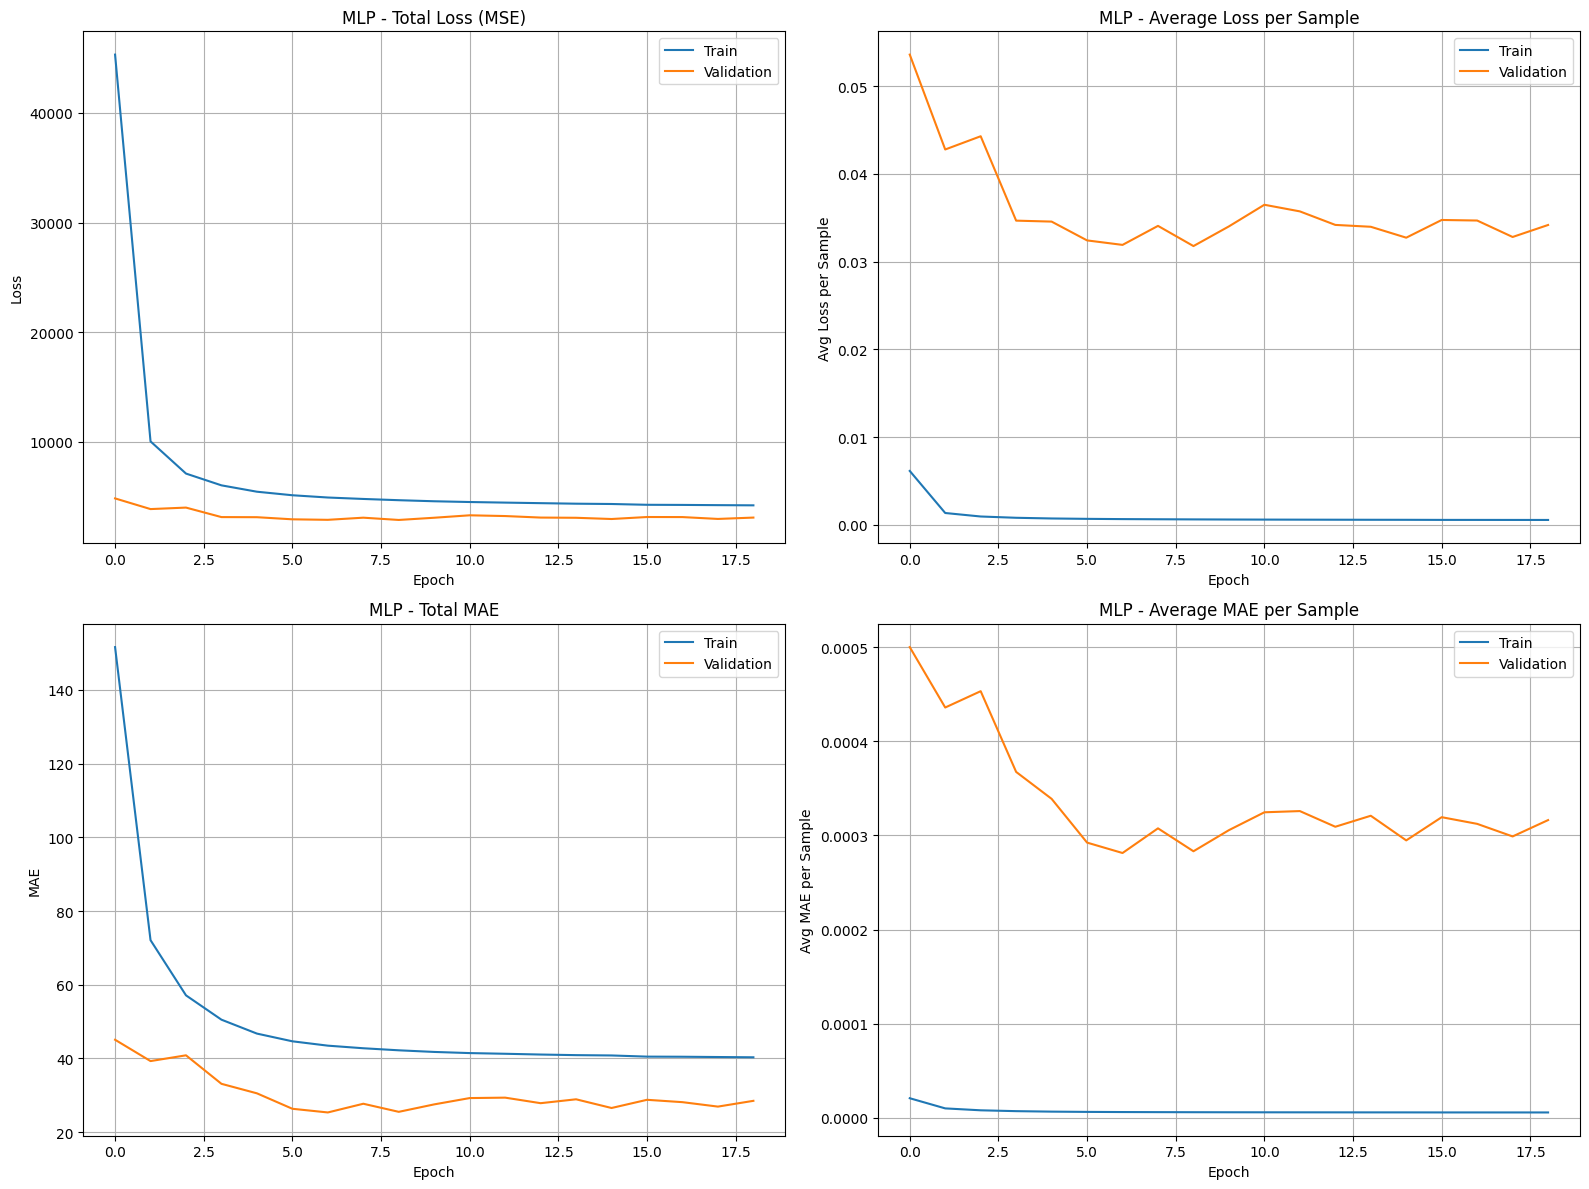


Evaluating MLP model on test set...

MLP - Test Evaluation Metrics:
  Overall:  MSE: 3021.96, RMSE: 54.97, MAE: 28.63, R²: 0.9687, WAPE: 12.37%
  Daytime:  MSE: 6052.13, RMSE: 77.80, MAE: 54.30, R²: 0.9293, WAPE: 11.70%
  Nighttime: MSE: 10.83, RMSE: 3.29, MAE: 3.12, R²: -3.3238, WAPE: 1008.14%
  Inference Speed: 8220033.10 samples/sec, 0.0001 ms/sample
  Total time: 0.0110 sec for 90112 samples
Model saved to checkpoints/MLP_best_20250430_173752.pt with metadata.
Best model saved to checkpoints/MLP_best_20250430_173752.pt
Saved model checkpoint logged to wandb: checkpoints/MLP_best_20250430_173752.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train/learning_rate,██████████████▁▁▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


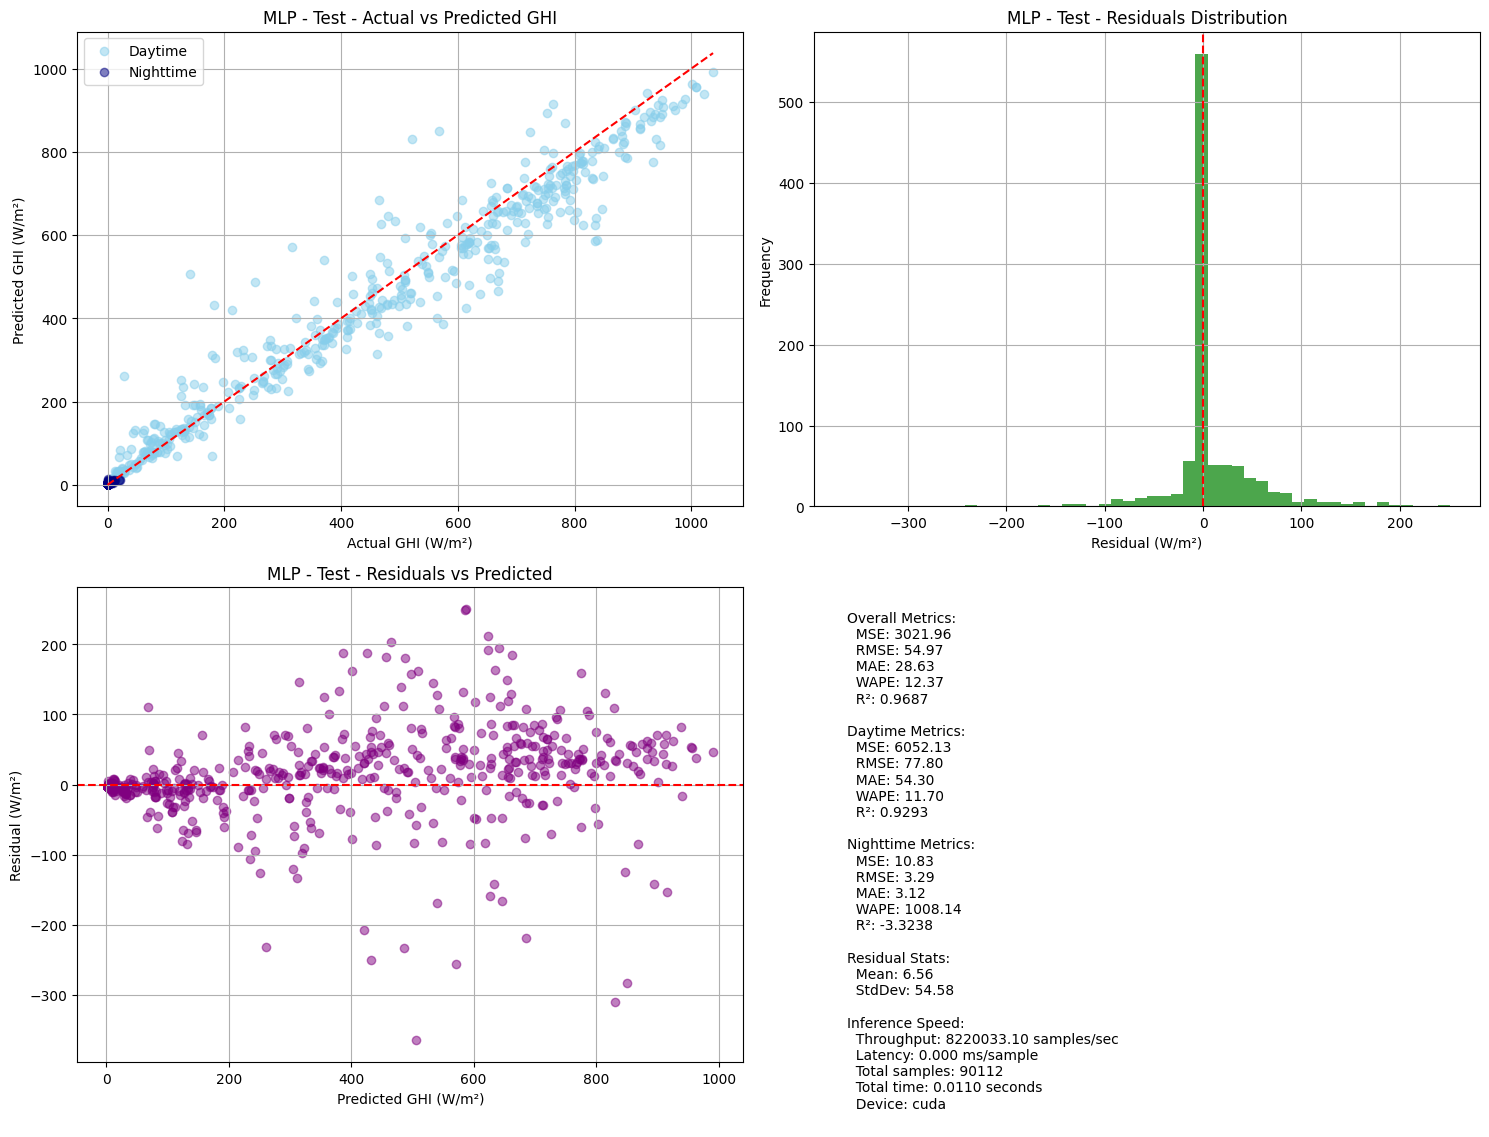

In [12]:
model_name = "MLP"

# Train the MLP model
mlp_history, mlp_val_metrics, mlp_test_metrics = run_experiment_pipeline(
    mlp_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.4 1D CNN Model

In [13]:
from models.cnn1d import CNN1DModel

# Create MLP model
cnn1d_model = CNN1DModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    num_filters=[64, 128, 256],
    kernel_sizes=[3, 3, 3],
    dropout=0.2
).to(device)

# Print the model
print_model_info(cnn1d_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: CNN1DModel
Total parameters: 176,097
Trainable parameters: 176,097
Non-trainable parameters: 0

Model structure:
CNN1DModel(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 25

Training 1D-CNN model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for 1D-CNN


Training config: {'PATIENCE': 10, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 


Validation 1D-CNN (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 8087.26, RMSE: 89.93, MAE: 65.69, R²: 0.9163, WAPE: 28.13%
  Daytime:  MSE: 14436.93, RMSE: 120.15, MAE: 95.49, R²: 0.8282, WAPE: 20.40%
  Nighttime: MSE: 1774.97, RMSE: 42.13, MAE: 36.06, R²: -686.8471, WAPE: 11413.53%
  Inference Speed: 9710879.01 samples/sec, 0.0001 ms/sample
  Total time: 0.0093 sec for 90112 samples
Epoch 1/30 | Train Loss: 42845.7617, Train MAE: 149.1994 | Val Loss: 8087.2627, Val MAE: 65.6890 | LR: 0.000100



Validation 1D-CNN (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 5991.30, RMSE: 77.40, MAE: 51.78, R²: 0.9380, WAPE: 22.18%
  Daytime:  MSE: 11390.67, RMSE: 106.73, MAE: 83.61, R²: 0.8645, WAPE: 17.86%
  Nighttime: MSE: 623.71, RMSE: 24.97, MAE: 20.14, R²: -240.7050, WAPE: 6373.26%
  Inference Speed: 10274482.74 samples/sec, 0.0001 ms/sample
  Total time: 0.0088 sec for 90112 samples
Epoch 2/30 | Train Loss: 12144.3428, Train MAE: 78.1789 | Val Loss: 5991.3003, Val MAE: 51.7804 | LR: 0.000100



Validation 1D-CNN (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 5205.92, RMSE: 72.15, MAE: 44.02, R²: 0.9461, WAPE: 18.85%
  Daytime:  MSE: 10271.92, RMSE: 101.35, MAE: 78.80, R²: 0.8778, WAPE: 16.84%
  Nighttime: MSE: 169.74, RMSE: 13.03, MAE: 9.45, R²: -64.7785, WAPE: 2990.48%
  Inference Speed: 8071177.97 samples/sec, 0.0001 ms/sample
  Total time: 0.0112 sec for 90112 samples
Epoch 3/30 | Train Loss: 8085.5181, Train MAE: 59.7665 | Val Loss: 5205.9189, Val MAE: 44.0209 | LR: 0.000100



Validation 1D-CNN (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 4864.71, RMSE: 69.75, MAE: 40.21, R²: 0.9496, WAPE: 17.22%
  Daytime:  MSE: 9698.82, RMSE: 98.48, MAE: 75.41, R²: 0.8846, WAPE: 16.11%
  Nighttime: MSE: 59.05, RMSE: 7.68, MAE: 5.22, R²: -21.8850, WAPE: 1651.09%
  Inference Speed: 10896218.24 samples/sec, 0.0001 ms/sample
  Total time: 0.0083 sec for 90112 samples
Epoch 4/30 | Train Loss: 6378.4648, Train MAE: 49.8170 | Val Loss: 4864.7080, Val MAE: 40.2114 | LR: 0.000100



Validation 1D-CNN (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 4755.43, RMSE: 68.96, MAE: 39.20, R²: 0.9508, WAPE: 16.79%
  Daytime:  MSE: 9496.74, RMSE: 97.45, MAE: 74.05, R²: 0.8870, WAPE: 15.82%
  Nighttime: MSE: 42.03, RMSE: 6.48, MAE: 4.56, R²: -15.2858, WAPE: 1443.23%
  Inference Speed: 9019595.31 samples/sec, 0.0001 ms/sample
  Total time: 0.0100 sec for 90112 samples
Epoch 5/30 | Train Loss: 5551.2021, Train MAE: 44.0437 | Val Loss: 4755.4258, Val MAE: 39.2008 | LR: 0.000100



Validation 1D-CNN (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 4586.27, RMSE: 67.72, MAE: 38.16, R²: 0.9525, WAPE: 16.34%
  Daytime:  MSE: 9169.46, RMSE: 95.76, MAE: 71.88, R²: 0.8909, WAPE: 15.36%
  Nighttime: MSE: 30.06, RMSE: 5.48, MAE: 4.63, R²: -10.6485, WAPE: 1465.19%
  Inference Speed: 10170526.94 samples/sec, 0.0001 ms/sample
  Total time: 0.0089 sec for 90112 samples
Epoch 6/30 | Train Loss: 5098.0195, Train MAE: 40.9906 | Val Loss: 4586.2715, Val MAE: 38.1560 | LR: 0.000100



Validation 1D-CNN (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 4257.40, RMSE: 65.25, MAE: 36.42, R²: 0.9559, WAPE: 15.60%
  Daytime:  MSE: 8511.55, RMSE: 92.26, MAE: 68.48, R²: 0.8987, WAPE: 14.63%
  Nighttime: MSE: 28.29, RMSE: 5.32, MAE: 4.54, R²: -9.9639, WAPE: 1437.37%
  Inference Speed: 8594818.01 samples/sec, 0.0001 ms/sample
  Total time: 0.0105 sec for 90112 samples
Epoch 7/30 | Train Loss: 4824.1758, Train MAE: 39.2274 | Val Loss: 4257.4004, Val MAE: 36.4177 | LR: 0.000100



Validation 1D-CNN (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 4186.85, RMSE: 64.71, MAE: 36.24, R²: 0.9567, WAPE: 15.52%
  Daytime:  MSE: 8371.31, RMSE: 91.49, MAE: 68.04, R²: 0.9004, WAPE: 14.54%
  Nighttime: MSE: 27.02, RMSE: 5.20, MAE: 4.63, R²: -9.4691, WAPE: 1466.27%
  Inference Speed: 5863800.45 samples/sec, 0.0002 ms/sample
  Total time: 0.0154 sec for 90112 samples
Epoch 8/30 | Train Loss: 4617.4717, Train MAE: 38.1083 | Val Loss: 4186.8472, Val MAE: 36.2432 | LR: 0.000100



Validation 1D-CNN (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 4174.48, RMSE: 64.61, MAE: 35.86, R²: 0.9568, WAPE: 15.36%
  Daytime:  MSE: 8352.61, RMSE: 91.39, MAE: 68.13, R²: 0.9006, WAPE: 14.56%
  Nighttime: MSE: 20.94, RMSE: 4.58, MAE: 3.79, R²: -7.1162, WAPE: 1198.29%
  Inference Speed: 8051919.94 samples/sec, 0.0001 ms/sample
  Total time: 0.0112 sec for 90112 samples
Epoch 9/30 | Train Loss: 4463.8105, Train MAE: 37.4579 | Val Loss: 4174.4795, Val MAE: 35.8613 | LR: 0.000100



Validation 1D-CNN (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3932.27, RMSE: 62.71, MAE: 34.24, R²: 0.9593, WAPE: 14.66%
  Daytime:  MSE: 7867.52, RMSE: 88.70, MAE: 65.27, R²: 0.9064, WAPE: 13.95%
  Nighttime: MSE: 20.18, RMSE: 4.49, MAE: 3.39, R²: -6.8190, WAPE: 1073.57%
  Inference Speed: 10661996.73 samples/sec, 0.0001 ms/sample
  Total time: 0.0085 sec for 90112 samples
Epoch 10/30 | Train Loss: 4346.1494, Train MAE: 37.0244 | Val Loss: 3932.2673, Val MAE: 34.2401 | LR: 0.000100



Validation 1D-CNN (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3959.09, RMSE: 62.92, MAE: 34.21, R²: 0.9590, WAPE: 14.65%
  Daytime:  MSE: 7918.90, RMSE: 88.99, MAE: 65.51, R²: 0.9058, WAPE: 14.00%
  Nighttime: MSE: 22.59, RMSE: 4.75, MAE: 3.10, R²: -7.7536, WAPE: 980.33%
  Inference Speed: 9164596.45 samples/sec, 0.0001 ms/sample
  Total time: 0.0098 sec for 90112 samples
Epoch 11/30 | Train Loss: 4242.3452, Train MAE: 36.6688 | Val Loss: 3959.0889, Val MAE: 34.2101 | LR: 0.000100



Validation 1D-CNN (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 4007.83, RMSE: 63.31, MAE: 35.25, R²: 0.9585, WAPE: 15.10%
  Daytime:  MSE: 8013.26, RMSE: 89.52, MAE: 66.63, R²: 0.9046, WAPE: 14.24%
  Nighttime: MSE: 25.98, RMSE: 5.10, MAE: 4.06, R²: -9.0690, WAPE: 1285.67%
  Inference Speed: 9866271.33 samples/sec, 0.0001 ms/sample
  Total time: 0.0091 sec for 90112 samples
Epoch 12/30 | Train Loss: 4156.7529, Train MAE: 36.3982 | Val Loss: 4007.8350, Val MAE: 35.2537 | LR: 0.000100



Validation 1D-CNN (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3673.53, RMSE: 60.61, MAE: 32.35, R²: 0.9620, WAPE: 13.85%
  Daytime:  MSE: 7350.17, RMSE: 85.73, MAE: 62.89, R²: 0.9125, WAPE: 13.44%
  Nighttime: MSE: 18.53, RMSE: 4.30, MAE: 1.99, R²: -6.1800, WAPE: 628.89%
  Inference Speed: 9817323.10 samples/sec, 0.0001 ms/sample
  Total time: 0.0092 sec for 90112 samples
Epoch 13/30 | Train Loss: 4092.3633, Train MAE: 36.1548 | Val Loss: 3673.5251, Val MAE: 32.3472 | LR: 0.000100



Validation 1D-CNN (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 4072.81, RMSE: 63.82, MAE: 34.77, R²: 0.9578, WAPE: 14.89%
  Daytime:  MSE: 8152.29, RMSE: 90.29, MAE: 67.88, R²: 0.9030, WAPE: 14.50%
  Nighttime: MSE: 17.35, RMSE: 4.17, MAE: 1.86, R²: -5.7238, WAPE: 588.09%
  Inference Speed: 10317958.07 samples/sec, 0.0001 ms/sample
  Total time: 0.0087 sec for 90112 samples
Epoch 14/30 | Train Loss: 4026.7175, Train MAE: 35.9595 | Val Loss: 4072.8115, Val MAE: 34.7694 | LR: 0.000100



Validation 1D-CNN (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3791.41, RMSE: 61.57, MAE: 32.69, R²: 0.9607, WAPE: 14.00%
  Daytime:  MSE: 7590.39, RMSE: 87.12, MAE: 64.06, R²: 0.9097, WAPE: 13.69%
  Nighttime: MSE: 14.80, RMSE: 3.85, MAE: 1.51, R²: -4.7356, WAPE: 479.45%
  Inference Speed: 9249599.19 samples/sec, 0.0001 ms/sample
  Total time: 0.0097 sec for 90112 samples
Epoch 15/30 | Train Loss: 3982.5103, Train MAE: 35.8391 | Val Loss: 3791.4124, Val MAE: 32.6929 | LR: 0.000100



Validation 1D-CNN (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3627.03, RMSE: 60.22, MAE: 31.44, R²: 0.9624, WAPE: 13.47%
  Daytime:  MSE: 7261.18, RMSE: 85.21, MAE: 61.76, R²: 0.9136, WAPE: 13.19%
  Nighttime: MSE: 14.26, RMSE: 3.78, MAE: 1.31, R²: -4.5280, WAPE: 413.59%
  Inference Speed: 7235290.82 samples/sec, 0.0001 ms/sample
  Total time: 0.0125 sec for 90112 samples
Epoch 16/30 | Train Loss: 3938.3606, Train MAE: 35.7423 | Val Loss: 3627.0276, Val MAE: 31.4423 | LR: 0.000100



Validation 1D-CNN (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3686.59, RMSE: 60.72, MAE: 33.23, R²: 0.9618, WAPE: 14.23%
  Daytime:  MSE: 7370.49, RMSE: 85.85, MAE: 63.22, R²: 0.9123, WAPE: 13.51%
  Nighttime: MSE: 24.36, RMSE: 4.94, MAE: 3.42, R²: -8.4408, WAPE: 1082.74%
  Inference Speed: 10942908.66 samples/sec, 0.0001 ms/sample
  Total time: 0.0082 sec for 90112 samples
Epoch 17/30 | Train Loss: 3903.8040, Train MAE: 35.6847 | Val Loss: 3686.5852, Val MAE: 33.2335 | LR: 0.000100



Validation 1D-CNN (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 3701.70, RMSE: 60.84, MAE: 33.39, R²: 0.9617, WAPE: 14.30%
  Daytime:  MSE: 7405.43, RMSE: 86.05, MAE: 63.64, R²: 0.9119, WAPE: 13.60%
  Nighttime: MSE: 19.77, RMSE: 4.45, MAE: 3.31, R²: -6.6599, WAPE: 1047.81%
  Inference Speed: 9833670.41 samples/sec, 0.0001 ms/sample
  Total time: 0.0092 sec for 90112 samples
Epoch 18/30 | Train Loss: 3874.9778, Train MAE: 35.6342 | Val Loss: 3701.6970, Val MAE: 33.3877 | LR: 0.000100



Validation 1D-CNN (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 3479.69, RMSE: 58.99, MAE: 31.81, R²: 0.9640, WAPE: 13.62%
  Daytime:  MSE: 6959.18, RMSE: 83.42, MAE: 60.27, R²: 0.9172, WAPE: 12.88%
  Nighttime: MSE: 20.68, RMSE: 4.55, MAE: 3.51, R²: -7.0139, WAPE: 1111.06%
  Inference Speed: 7170501.27 samples/sec, 0.0001 ms/sample
  Total time: 0.0126 sec for 90112 samples
Epoch 19/30 | Train Loss: 3839.9700, Train MAE: 35.5456 | Val Loss: 3479.6899, Val MAE: 31.8089 | LR: 0.000100



Validation 1D-CNN (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 3840.13, RMSE: 61.97, MAE: 33.99, R²: 0.9602, WAPE: 14.56%
  Daytime:  MSE: 7690.39, RMSE: 87.69, MAE: 65.36, R²: 0.9085, WAPE: 13.96%
  Nighttime: MSE: 12.53, RMSE: 3.54, MAE: 2.81, R²: -3.8565, WAPE: 887.96%
  Inference Speed: 10575777.10 samples/sec, 0.0001 ms/sample
  Total time: 0.0085 sec for 90112 samples
Epoch 20/30 | Train Loss: 3810.3904, Train MAE: 35.4559 | Val Loss: 3840.1287, Val MAE: 33.9904 | LR: 0.000100



Validation 1D-CNN (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 3555.48, RMSE: 59.63, MAE: 31.53, R²: 0.9632, WAPE: 13.51%
  Daytime:  MSE: 7123.50, RMSE: 84.40, MAE: 61.59, R²: 0.9152, WAPE: 13.16%
  Nighttime: MSE: 8.46, RMSE: 2.91, MAE: 1.65, R²: -2.2780, WAPE: 522.10%
  Inference Speed: 6863586.58 samples/sec, 0.0001 ms/sample
  Total time: 0.0131 sec for 90112 samples
Epoch 21/30 | Train Loss: 3792.7166, Train MAE: 35.4350 | Val Loss: 3555.4790, Val MAE: 31.5324 | LR: 0.000100



Validation 1D-CNN (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 3513.83, RMSE: 59.28, MAE: 31.32, R²: 0.9636, WAPE: 13.42%
  Daytime:  MSE: 7036.76, RMSE: 83.89, MAE: 61.14, R²: 0.9163, WAPE: 13.06%
  Nighttime: MSE: 11.63, RMSE: 3.41, MAE: 1.69, R²: -3.5055, WAPE: 533.76%
  Inference Speed: 6621185.33 samples/sec, 0.0002 ms/sample
  Total time: 0.0136 sec for 90112 samples
Epoch 22/30 | Train Loss: 3768.3655, Train MAE: 35.3639 | Val Loss: 3513.8264, Val MAE: 31.3236 | LR: 0.000100



Validation 1D-CNN (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 3600.03, RMSE: 60.00, MAE: 32.25, R²: 0.9627, WAPE: 13.81%
  Daytime:  MSE: 7209.91, RMSE: 84.91, MAE: 62.54, R²: 0.9142, WAPE: 13.36%
  Nighttime: MSE: 11.40, RMSE: 3.38, MAE: 2.13, R²: -3.4161, WAPE: 675.58%
  Inference Speed: 7796627.72 samples/sec, 0.0001 ms/sample
  Total time: 0.0116 sec for 90112 samples
Epoch 23/30 | Train Loss: 3746.1187, Train MAE: 35.3128 | Val Loss: 3600.0276, Val MAE: 32.2484 | LR: 0.000100



Validation 1D-CNN (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 3533.98, RMSE: 59.45, MAE: 31.43, R²: 0.9634, WAPE: 13.46%
  Daytime:  MSE: 7080.67, RMSE: 84.15, MAE: 61.58, R²: 0.9157, WAPE: 13.16%
  Nighttime: MSE: 8.17, RMSE: 2.86, MAE: 1.45, R²: -2.1653, WAPE: 459.29%
  Inference Speed: 8495327.54 samples/sec, 0.0001 ms/sample
  Total time: 0.0106 sec for 90112 samples
Epoch 24/30 | Train Loss: 3726.3250, Train MAE: 35.2572 | Val Loss: 3533.9812, Val MAE: 31.4269 | LR: 0.000100



Validation 1D-CNN (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 3588.79, RMSE: 59.91, MAE: 31.91, R²: 0.9628, WAPE: 13.67%
  Daytime:  MSE: 7189.29, RMSE: 84.79, MAE: 61.91, R²: 0.9144, WAPE: 13.23%
  Nighttime: MSE: 9.48, RMSE: 3.08, MAE: 2.10, R²: -2.6750, WAPE: 663.61%
  Inference Speed: 10925195.03 samples/sec, 0.0001 ms/sample
  Total time: 0.0082 sec for 90112 samples
Epoch 25/30 | Train Loss: 3705.1411, Train MAE: 35.1861 | Val Loss: 3588.7869, Val MAE: 31.9149 | LR: 0.000050



Validation 1D-CNN (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 3446.75, RMSE: 58.71, MAE: 30.98, R²: 0.9643, WAPE: 13.27%
  Daytime:  MSE: 6902.79, RMSE: 83.08, MAE: 60.05, R²: 0.9179, WAPE: 12.83%
  Nighttime: MSE: 11.06, RMSE: 3.33, MAE: 2.09, R²: -3.2861, WAPE: 661.63%
  Inference Speed: 9844940.79 samples/sec, 0.0001 ms/sample
  Total time: 0.0092 sec for 90112 samples
Epoch 26/30 | Train Loss: 3679.0554, Train MAE: 35.0706 | Val Loss: 3446.7549, Val MAE: 30.9848 | LR: 0.000050



Validation 1D-CNN (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 3435.70, RMSE: 58.61, MAE: 31.39, R²: 0.9644, WAPE: 13.44%
  Daytime:  MSE: 6875.24, RMSE: 82.92, MAE: 59.73, R²: 0.9182, WAPE: 12.76%
  Nighttime: MSE: 16.40, RMSE: 4.05, MAE: 3.22, R²: -5.3565, WAPE: 1018.24%
  Inference Speed: 9612337.79 samples/sec, 0.0001 ms/sample
  Total time: 0.0094 sec for 90112 samples
Epoch 27/30 | Train Loss: 3668.4993, Train MAE: 35.0495 | Val Loss: 3435.6992, Val MAE: 31.3891 | LR: 0.000050



Validation 1D-CNN (Epoch 28) Evaluation Metrics:
  Overall:  MSE: 3578.08, RMSE: 59.82, MAE: 31.90, R²: 0.9630, WAPE: 13.66%
  Daytime:  MSE: 7168.80, RMSE: 84.67, MAE: 62.17, R²: 0.9147, WAPE: 13.28%
  Nighttime: MSE: 8.50, RMSE: 2.92, MAE: 1.82, R²: -2.2940, WAPE: 576.73%
  Inference Speed: 8794813.78 samples/sec, 0.0001 ms/sample
  Total time: 0.0102 sec for 90112 samples
Epoch 28/30 | Train Loss: 3660.9966, Train MAE: 35.0219 | Val Loss: 3578.0837, Val MAE: 31.9048 | LR: 0.000050



Validation 1D-CNN (Epoch 29) Evaluation Metrics:
  Overall:  MSE: 3485.95, RMSE: 59.04, MAE: 31.37, R²: 0.9639, WAPE: 13.44%
  Daytime:  MSE: 6981.45, RMSE: 83.56, MAE: 60.85, R²: 0.9169, WAPE: 13.00%
  Nighttime: MSE: 11.02, RMSE: 3.32, MAE: 2.07, R²: -3.2713, WAPE: 654.83%
  Inference Speed: 6497122.76 samples/sec, 0.0002 ms/sample
  Total time: 0.0139 sec for 90112 samples
Epoch 29/30 | Train Loss: 3644.6562, Train MAE: 34.9792 | Val Loss: 3485.9502, Val MAE: 31.3711 | LR: 0.000050



Validation 1D-CNN (Epoch 30) Evaluation Metrics:
  Overall:  MSE: 3409.86, RMSE: 58.39, MAE: 31.24, R²: 0.9647, WAPE: 13.38%
  Daytime:  MSE: 6827.51, RMSE: 82.63, MAE: 59.87, R²: 0.9188, WAPE: 12.79%
  Nighttime: MSE: 12.32, RMSE: 3.51, MAE: 2.78, R²: -3.7740, WAPE: 878.85%
  Inference Speed: 12839525.84 samples/sec, 0.0001 ms/sample
  Total time: 0.0070 sec for 90112 samples
Epoch 30/30 | Train Loss: 3637.4475, Train MAE: 34.9532 | Val Loss: 3409.8557, Val MAE: 31.2382 | LR: 0.000050
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


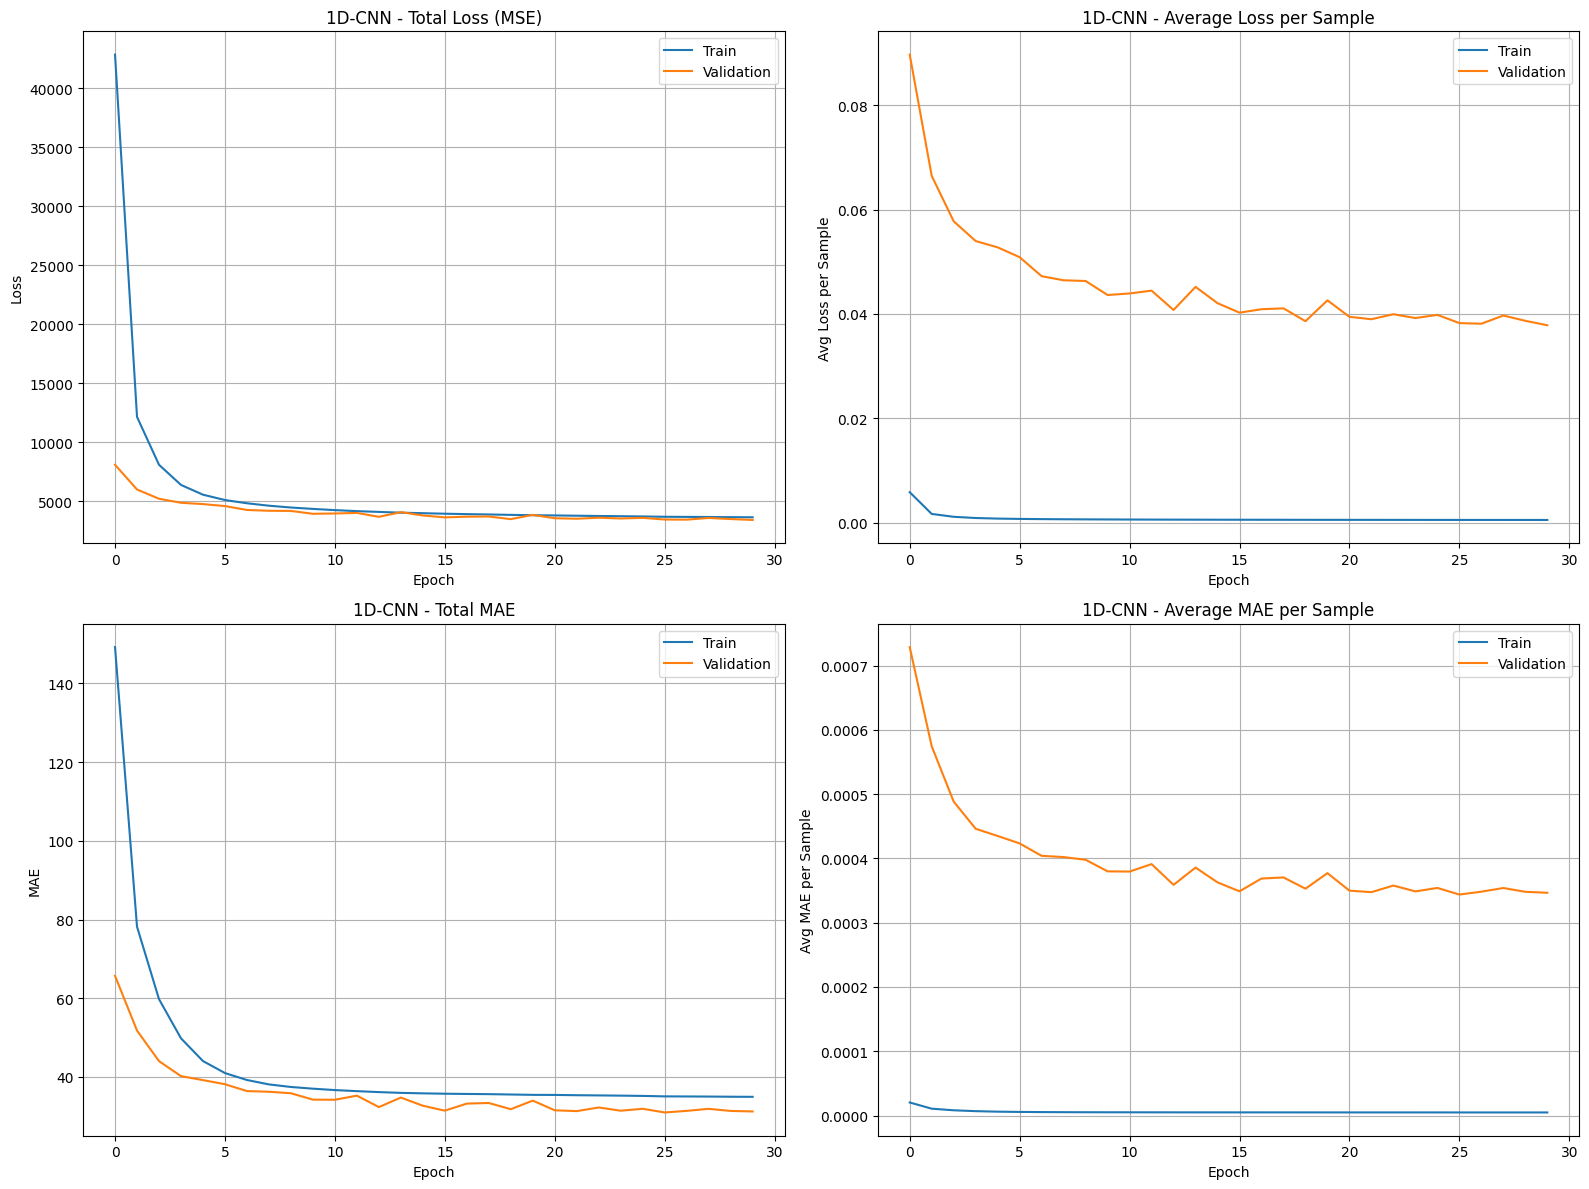


Evaluating 1D-CNN model on test set...

1D-CNN - Test Evaluation Metrics:
  Overall:  MSE: 3384.34, RMSE: 58.18, MAE: 31.31, R²: 0.9649, WAPE: 13.53%
  Daytime:  MSE: 6778.40, RMSE: 82.33, MAE: 60.15, R²: 0.9208, WAPE: 12.97%
  Nighttime: MSE: 11.62, RMSE: 3.41, MAE: 2.65, R²: -3.6372, WAPE: 855.55%
  Inference Speed: 9660492.84 samples/sec, 0.0001 ms/sample
  Total time: 0.0093 sec for 90112 samples
Model saved to checkpoints/1D-CNN_best_20250430_182648.pt with metadata.
Best model saved to checkpoints/1D-CNN_best_20250430_182648.pt
Saved model checkpoint logged to wandb: checkpoints/1D-CNN_best_20250430_182648.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/learning_rate,████████████████████████▁▁▁▁▁▁
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


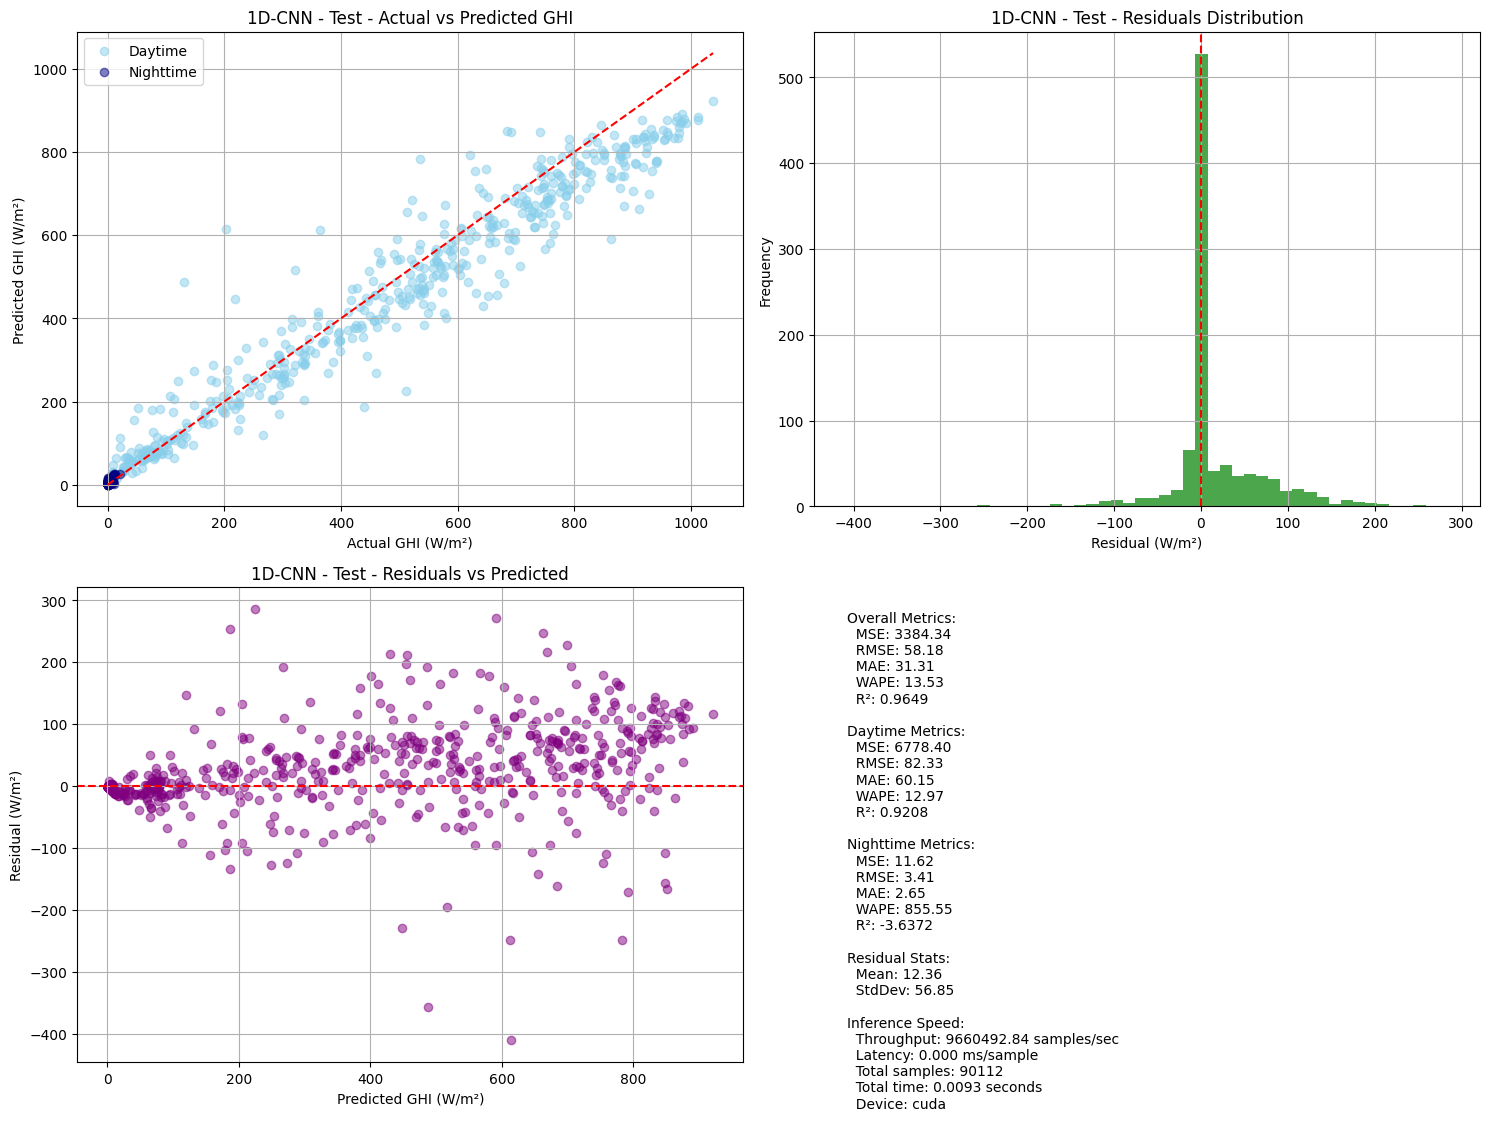

In [14]:
model_name = "1D-CNN"

# Train the MLP model
cnn1d_history, cnn1d_val_metrics, cnn1d_test_metrics = run_experiment_pipeline(
    cnn1d_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

## 4. Model Comparison

## 4.1 Compare Models' Performance


Test Set Comparison:

Model Comparison - Test Set:
                       LSTM        CNN-LSTM             MLP          1D-CNN
MSE             2826.120605     2900.390381     3021.960693     3384.343994
RMSE               53.16127       53.855273       54.972363       58.175115
MAE               27.743853       27.590906       28.627205       31.309027
WAPE              11.991508       11.925403       12.373313       13.532456
R²                 0.970685        0.969915        0.968654        0.964895
Samples/sec  7675191.333929  6121754.487334  8220033.102392  9660492.844494
ms/sample           0.00013        0.000163        0.000122        0.000104
Input DataFrame for visualization:
                       LSTM        CNN-LSTM             MLP          1D-CNN
MSE             2826.120605     2900.390381     3021.960693     3384.343994
RMSE               53.16127       53.855273       54.972363       58.175115
MAE               27.743853       27.590906       28.627205       31.309027
W

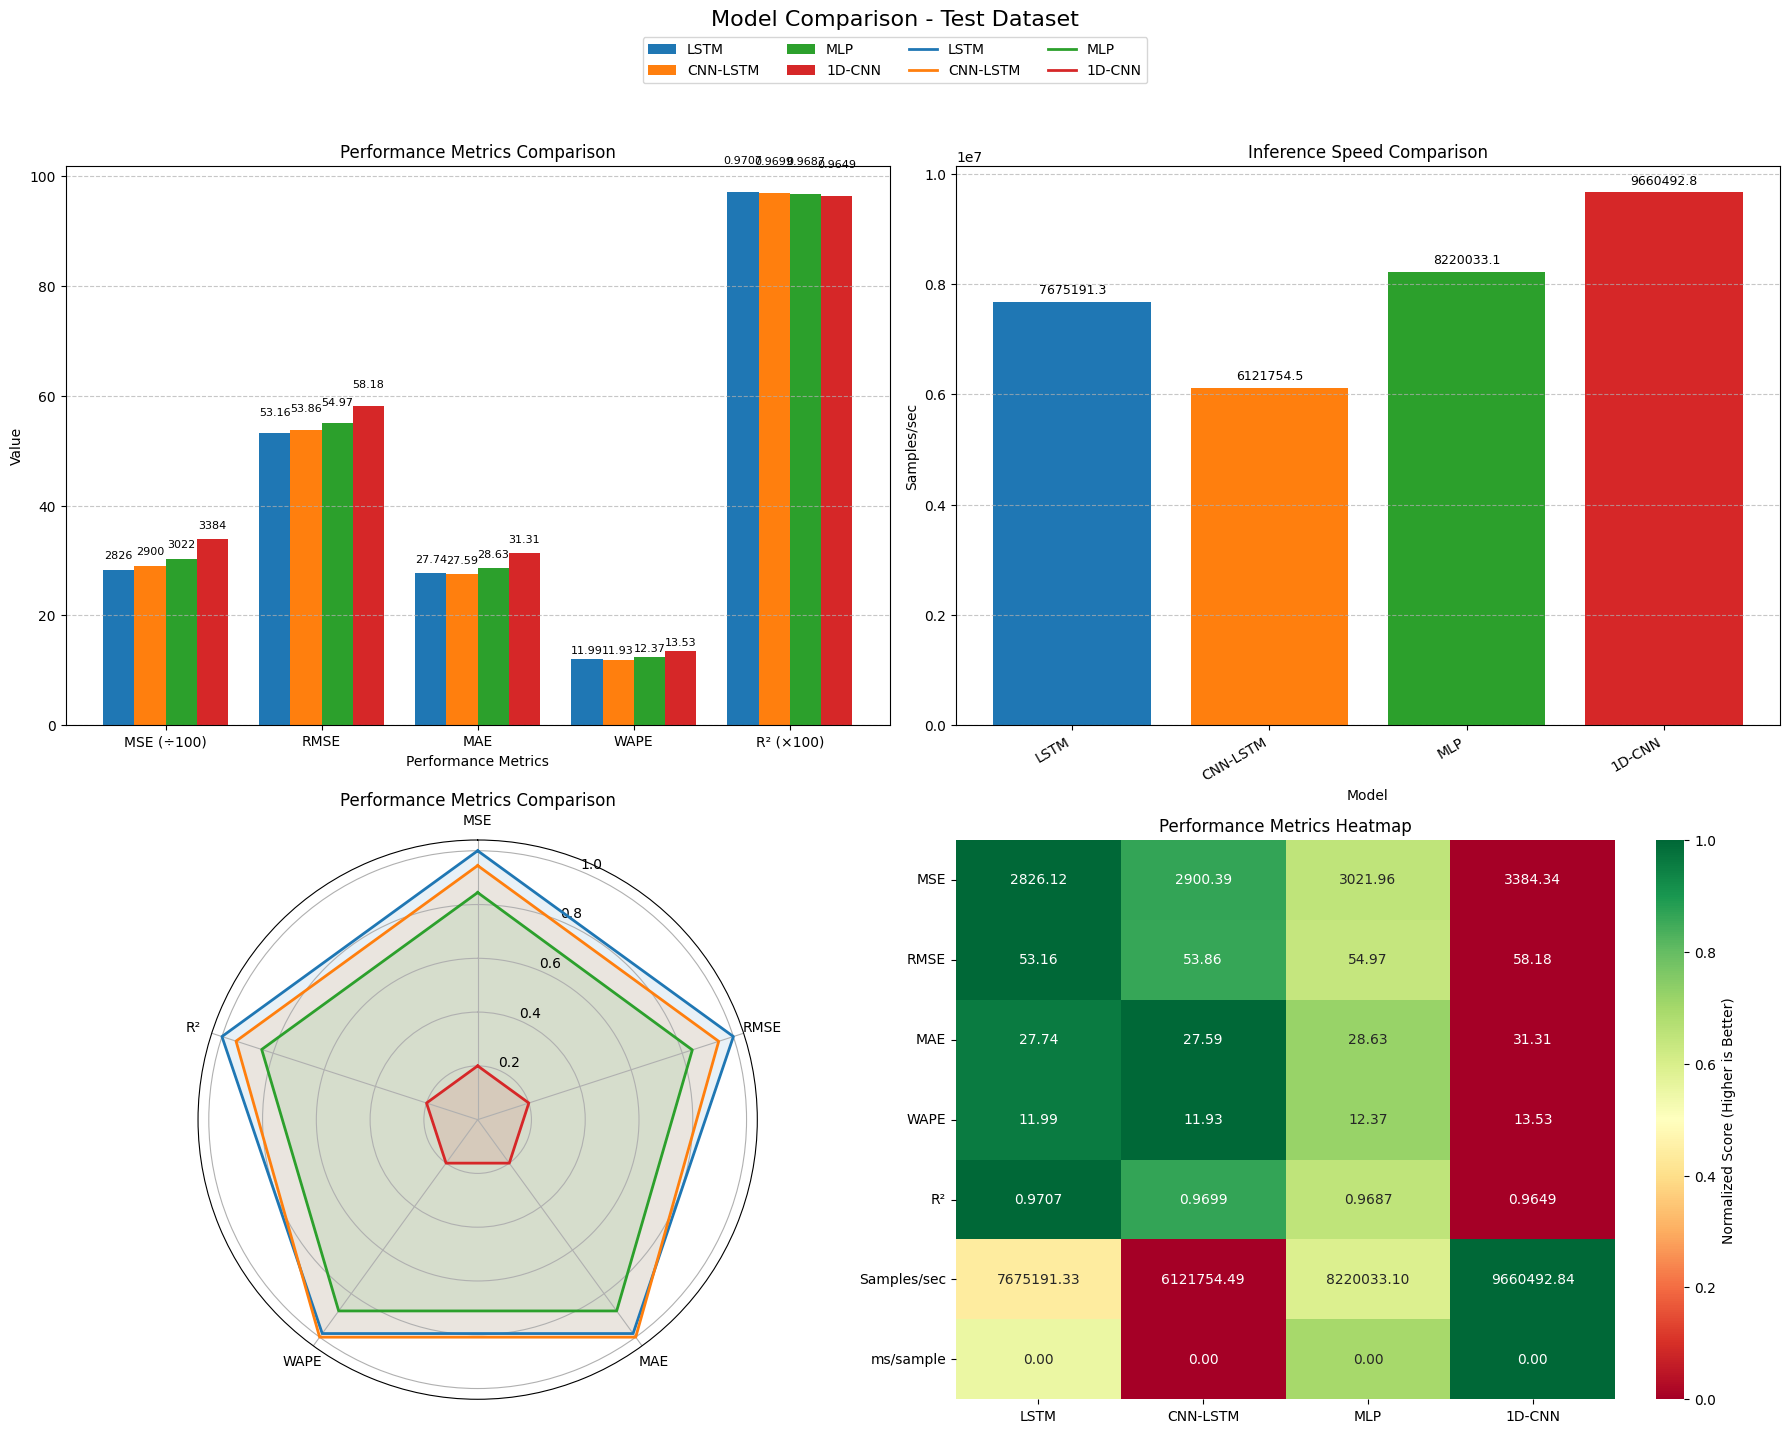

(                       LSTM        CNN-LSTM             MLP          1D-CNN
 MSE             2826.120605     2900.390381     3021.960693     3384.343994
 RMSE               53.16127       53.855273       54.972363       58.175115
 MAE               27.743853       27.590906       28.627205       31.309027
 WAPE              11.991508       11.925403       12.373313       13.532456
 R²                 0.970685        0.969915        0.968654        0.964895
 Samples/sec  7675191.333929  6121754.487334  8220033.102392  9660492.844494
 ms/sample           0.00013        0.000163        0.000122        0.000104,
 <Figure size 1800x2100 with 5 Axes>)

<Figure size 640x480 with 0 Axes>

In [15]:
from utils.plot_utils import compare_models

# Create a dictionary of model metrics
model_metrics = {
    'LSTM': lstm_test_metrics,
    'CNN-LSTM': cnn_lstm_test_metrics,
    'MLP': mlp_test_metrics,
    '1D-CNN': cnn1d_test_metrics
}

# Compare model performance on test set
print("\nTest Set Comparison:")
compare_models(model_metrics, dataset_name='Test')

## 4.2 Model Comparison on Daytime/Nighttime/Overall

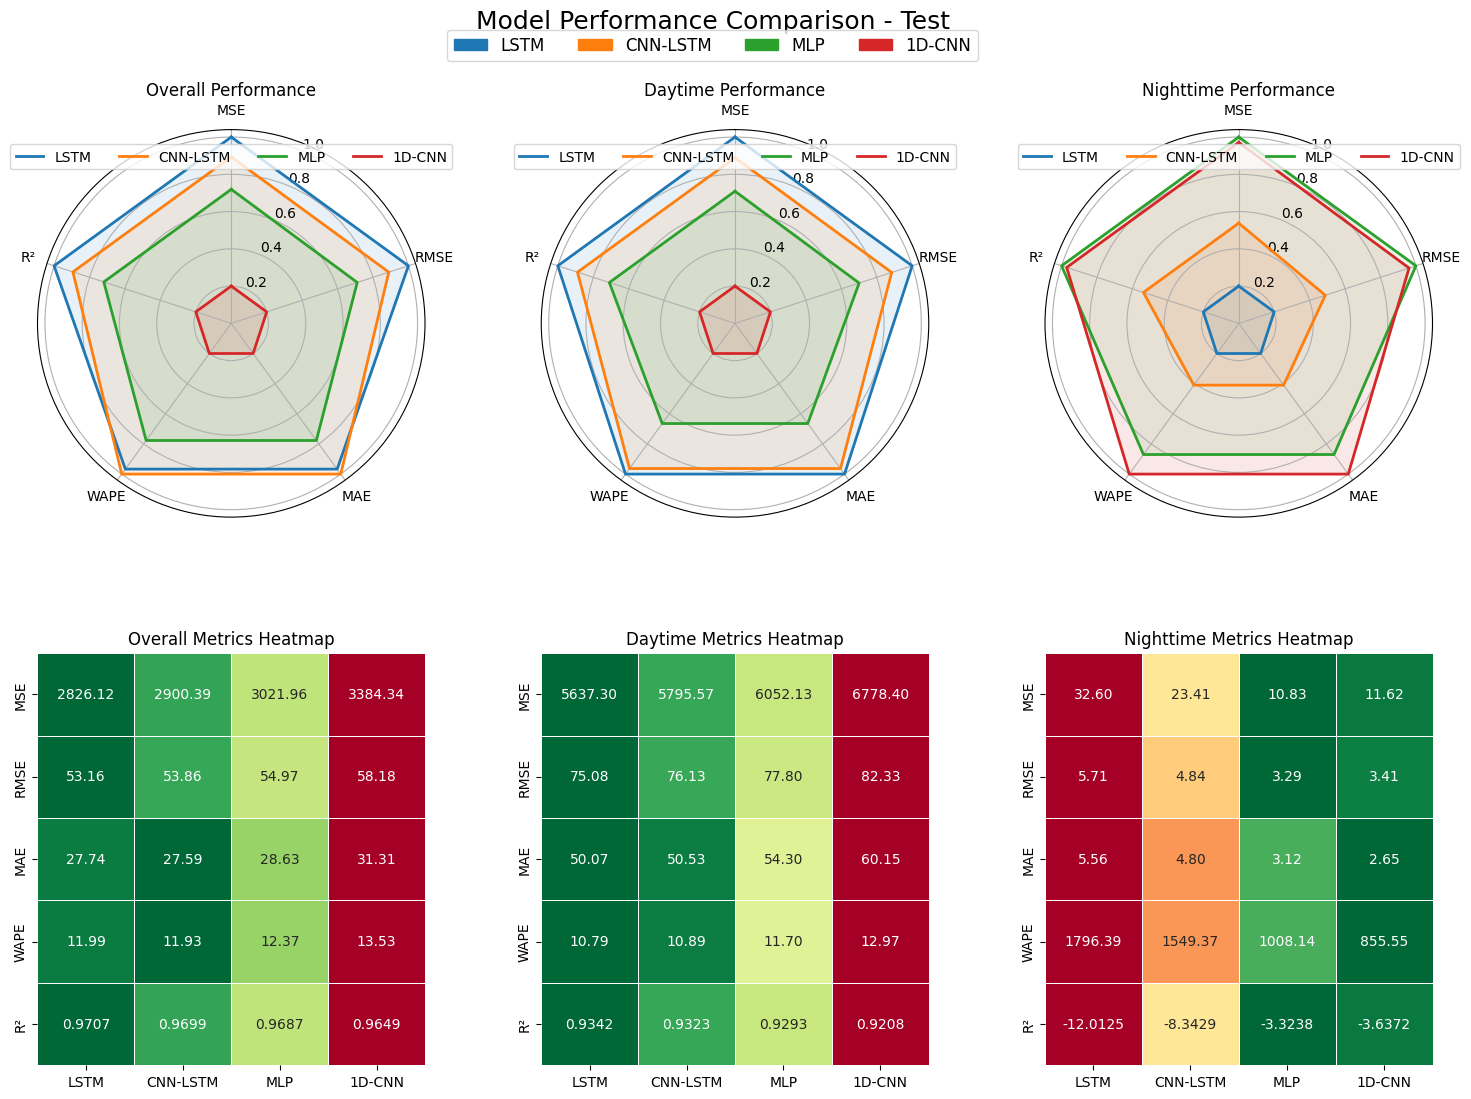

In [16]:
from utils.plot_utils import compare_models_daytime_nighttime

# Create a dictionary of model metrics
model_metrics = {
    'LSTM': lstm_test_metrics,
    'CNN-LSTM': cnn_lstm_test_metrics,
    'MLP': mlp_test_metrics,
    '1D-CNN': cnn1d_test_metrics
}

# Generate the comparison plot
comparison_fig = compare_models_daytime_nighttime(model_metrics, dataset_name='Test')

## 5. Train and Evaluate Models

### 5.2 Time Series Predictions

Visualize predictions over time.

In [17]:
def plot_predictions_over_time(models, model_names, data_loader, target_scaler, num_samples=200, start_idx=0):
    """
    Plot time series predictions for multiple models with nighttime shading if available

    Args:
        models: List of PyTorch models
        model_names: List of model names
        data_loader: Data loader
        target_scaler: Scaler for the target variable
        num_samples: Number of consecutive time steps to plot
        start_idx: Starting index in the dataset
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from matplotlib.patches import Patch
    import matplotlib.dates as mdates
    from datetime import datetime

    # Get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect data samples
    all_batches = []
    for batch in data_loader:
        all_batches.append(batch)
        if len(all_batches) * batch['target'].shape[0] > start_idx + num_samples:
            break

    # Combine batches into a single dataset
    all_temporal = []
    all_static = []
    all_targets = []
    all_nighttime = []
    all_time_index_local = []
    has_nighttime = False
    has_time_index_local = False

    for batch in all_batches:
        all_temporal.append(batch['temporal_features'])
        all_static.append(batch['static_features'])
        all_targets.append(batch['target'])
        # Check if nighttime data is available
        if 'nighttime_mask' in batch:
            has_nighttime = True
            all_nighttime.append(batch['nighttime_mask'])
        # Check if time_index_local is available
        if 'time_index_local' in batch:
            has_time_index_local = True
            # Store the time index values as they are
            if isinstance(batch['time_index_local'], list):
                all_time_index_local.extend(batch['time_index_local'])
            else:
                all_time_index_local.append(batch['time_index_local'])

    all_temporal = torch.cat(all_temporal, dim=0)
    all_static = torch.cat(all_static, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    if has_nighttime:
        all_nighttime = torch.cat(all_nighttime, dim=0)

    # Get the subset for visualization
    temporal = all_temporal[start_idx:start_idx+num_samples].to(device)
    static = all_static[start_idx:start_idx+num_samples].to(device)
    targets = all_targets[start_idx:start_idx+num_samples].cpu().numpy()

    if has_nighttime:
        nighttime = all_nighttime[start_idx:start_idx+num_samples].cpu().numpy()
        # Ensure nighttime is a 1D array
        if len(nighttime.shape) > 1:
            nighttime = nighttime.flatten() if nighttime.shape[1] == 1 else nighttime[:,0]

    # Get time index for x-axis if available
    x_values = None
    if has_time_index_local and len(all_time_index_local) >= start_idx + num_samples:
        # Extract the time values for the plotting window
        x_values = all_time_index_local[start_idx:start_idx+num_samples]

        # Try to convert to datetime objects if they are strings
        if isinstance(x_values[0], str):
            try:
                # Try different datetime formats
                date_formats = ['%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%Y-%m-%dT%H:%M:%S', '%Y%m%d%H%M%S']
                for date_format in date_formats:
                    try:
                        x_values = [datetime.strptime(t, date_format) for t in x_values]
                        print(f"Successfully parsed dates with format: {date_format}")
                        break
                    except ValueError:
                        continue

                # If we couldn't parse with any format, notify and use indices
                if isinstance(x_values[0], str):
                    print(f"Could not parse date format: {x_values[0]}, using indices instead")
                    x_values = None

            except (ValueError, TypeError) as e:
                # If conversion fails, fall back to using indices
                print(f"Error converting time_index_local to datetime: {e}, using indices instead")
                x_values = None

    # Generate predictions
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(temporal, static).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform to original scale
    y_true_orig = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    y_pred_orig_list = [target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

    # Create visualization
    fig = plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # Define colors and line styles for predictions
    colors = ['blue', 'red', 'green', 'magenta', 'cyan', 'orange']
    line_styles = ['--', ':', '-.', '--', ':', '--']

    # Set x-axis values based on availability of time_index_local
    if x_values:
        # Plot actual values with time index
        actual_line, = plt.plot(x_values, y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions with time index
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(x_values, pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # Format the x-axis to show dates properly
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=0)  # Make labels horizontal
        fig.subplots_adjust(bottom=0.15)  # Adjust bottom margin for horizontal labels

        # If we have nighttime data, shade those regions
        if has_nighttime:
            # Modify nighttime shading to work with datetime x-axis
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                if start < len(x_values) and end <= len(x_values):
                    ax.axvspan(x_values[start], x_values[min(end, len(x_values)-1)],
                              alpha=0.2, color='gray', label='_nolegend_')
    else:
        # Use default integer indices for x-axis
        actual_line, = plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions and collect handles/labels
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # If we have nighttime data, shade those regions
        if has_nighttime:
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                ax.axvspan(start, end, alpha=0.2, color='gray', label='_nolegend_')

    # Add nighttime legend if applicable
    if has_nighttime and len(night_regions) > 0:
        night_patch = Patch(facecolor='gray', alpha=0.2, label='Nighttime')
        handles.append(night_patch)
        labels.append('Nighttime')

    # Calculate and display error metrics for the visualization window
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        rmse = np.sqrt(np.mean((y_true_orig - pred) ** 2))
        mae = np.mean(np.abs(y_true_orig - pred))
        plt.annotate(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}",
                     xy=(0.02, 0.97 - 0.03*i),
                     xycoords='axes fraction',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time' if x_values else 'Time Step')
    plt.ylabel('GHI (W/m²)')

    # Set the legend with the correct handles and labels
    plt.legend(handles, labels, loc='upper right')

    plt.grid(True)
    plt.tight_layout()
    # Save the figure
    os.makedirs('plots', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'plots/predictions_over_time_{timestamp}.png')
    return fig

Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


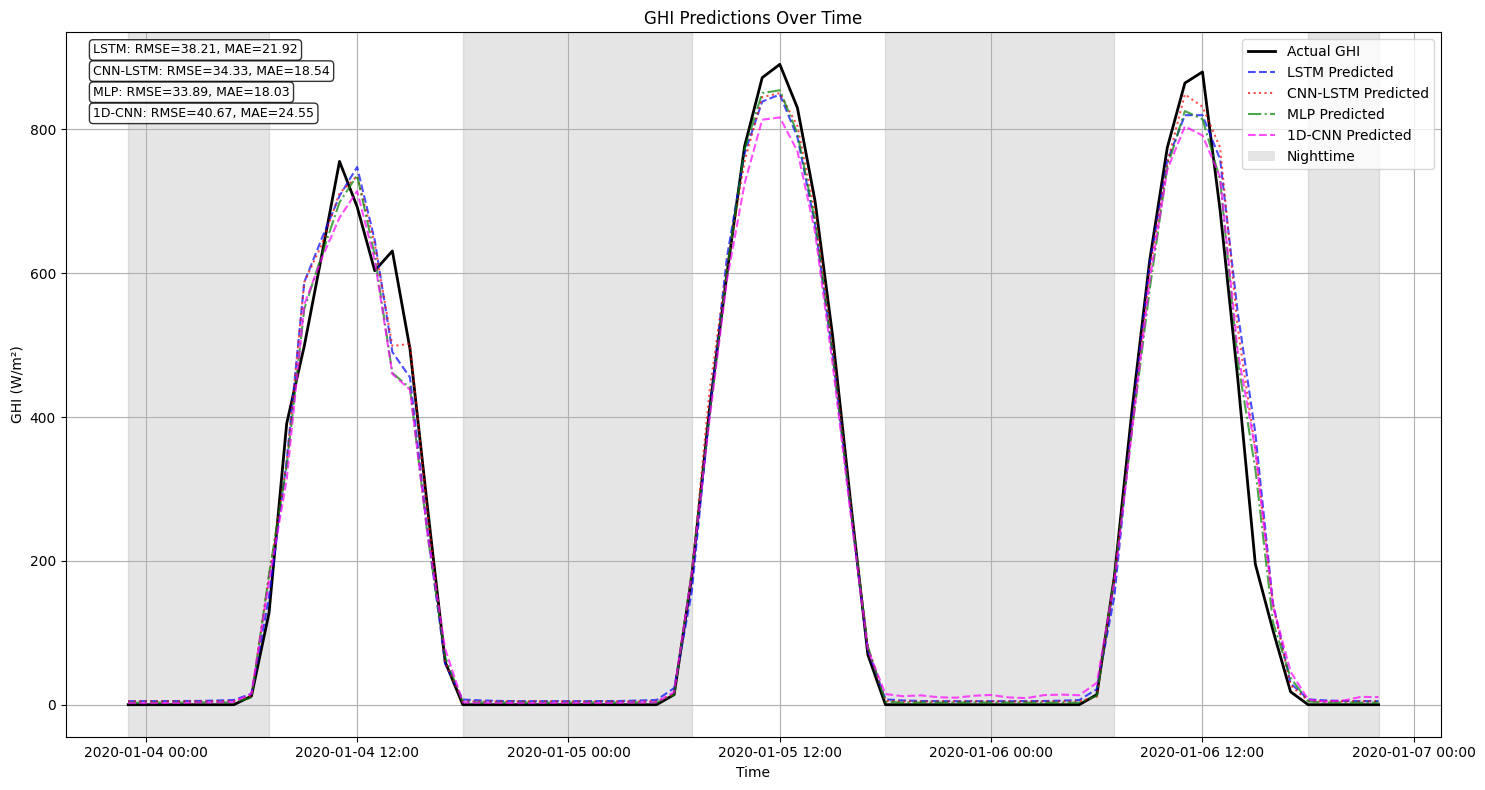

In [18]:
# Plot time series predictions
_ = plot_predictions_over_time(
    models=[lstm_model, cnn_lstm_model, mlp_model, cnn1d_model],
    model_names=['LSTM', 'CNN-LSTM', 'MLP', '1D-CNN'],
    data_loader=test_loader,
    target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
    num_samples=72,
    start_idx=40
)

